Alejandro Salgado - Analítica Predictiva - Octubre 2023

# **Caso Práctico - BDD Final**

## **1. Introducción**

El objetivo principal de este análisis es modelar y predecir las ventas semanales de Walmart en función de diversas variables, como la temperatura, el precio del combustible, el índice de precios al consumidor (IPC), la tasa de desempleo y la presencia de festividades. Al entender cómo estos factores impactan las ventas, Walmart puede tomar decisiones más informadas sobre la gestión del inventario, las promociones de marketing y otros aspectos clave de su operación.

## **2. Importación de librerías y de la base de datos**

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels import PooledOLS, PanelOLS, RandomEffects
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
import warnings
warnings.filterwarnings("ignore")

In [93]:
df = pd.read_csv("Walmart(1).csv")

## **3. Descripción y Tratamiento de los Datos**

### 3.1. Estructura de los datos

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


La base de datos contiene 6,435 entradas. Posee ocho columnas: 'Store' (entero), 'Date' (objeto/string), 'Weekly_Sales' (flotante), 'Holiday_Flag' (entero), 'Temperature' (flotante), 'Fuel_Price' (flotante), 'CPI' (flotante) y 'Unemployment' (flotante). Todas las columnas tienen 6,435 valores no nulos, lo que indica que no hay valores faltantes en el DataFrame.

In [95]:
# Traducción de los nombres de la columna a español
nombres_columnas = {
    'Store': 'Tienda',
    'Date': 'Fecha',
    'Weekly_Sales': 'Ventas_Semanales',
    'Holiday_Flag': 'Bandera_Festivo',
    'Temperature': 'Temperatura',
    'Fuel_Price': 'Precio_Combustible',
    'CPI': 'IPC',
    'Unemployment': 'Desempleo'
}
df.rename(columns=nombres_columnas, inplace=True)

### 3.2. Visualización de los Datos

In [96]:
df

,Tienda,Fecha,Ventas_Semanales,Bandera_Festivo,Temperatura,Precio_Combustible,IPC,Desempleo
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


A primera vista, se pueden realizar las siguientes observaciones:

- Tienda: Representa un identificador numérico de las tiendas. En el fragmento de datos mostrado, vemos que comienza en 1 y termina en 45.
- Fecha: Las fechas están en formato dd-mm-yyyy. Estas fechas abarcan desde febrero de 2010 hasta octubre de 2012, lo que indica que se tienen registros de ventas durante este período.
- Ventas_Semanales: Representa las ventas de la tienda durante la semana dada. Las ventas varían, pero en los datos proporcionados parecen estar principalmente en el rango de millones, lo que indica que se están representando ventas totales.
- Bandera_Festivo: Es una variable binaria donde 1 indica que la semana es especial (semana festiva) y 0 indica que no lo es. La mayoría de las semanas no son festivas, pero hay algunas que sí lo son, como el 12-02-2010.
- Temperatura: Se refiere a la temperatura promedio durante la semana de venta. Los valores oscilan en el rango mostrado entre aproximadamente 38 y 65 grados, lo que sugiere que estos valores están en grados Fahrenheit.
- Precio_Combustible: Muestra el costo del combustible en la región durante esa semana. Los valores oscilan en el rango mostrado entre aproximadamente 2.5 y 4.0, lo que indica que ha habido variaciones en el precio del combustible durante el período de tiempo en cuestión.
- IPC (Índice de Precios al Consumidor): Representa el IPC vigente para esa semana. Parece que hay ligeras fluctuaciones en este valor a lo largo del tiempo.
- Desempleo: Indica la tasa de desempleo predominante.

### 3.3. Descripción y visualización de los datos numéricos

In [97]:
df.describe()

,Tienda,Ventas_Semanales,Bandera_Festivo,Temperatura,Precio_Combustible,IPC,Desempleo
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


En promedio, las ventas semanales son de aproximadamente 1.04 millones de dólares, aunque hay una considerable variabilidad con una desviación estándar de 564,366 dólares y un rango que va desde 209,986 hasta 3.82 millones de dólares. Solo alrededor del 7% de las semanas se consideran festivas. La temperatura promedio durante este período es de alrededor de 60.66 grados Fahrenheit, variando desde un mínimo de -2.06 hasta un máximo de 100.14 grados. El precio del combustible tiene un promedio de 3.36 con una desviación estándar de 0.46, oscilando entre 2.472 y 4.468. El Índice de Precios al Consumidor (IPC) promedio es de 171.58, pero ha variado entre 126.06 y 227.23. Por último, la tasa de desempleo promedio es de aproximadamente 8%, con un rango que va desde 3.879% hasta 14.313%.

Dado que el número de tienda es un identificador categórico, se procede a cambiar su tipo.

In [98]:
df["Tienda"] = df["Tienda"].astype(dtype="object")

Procedemos a graficar los datos numéricos:

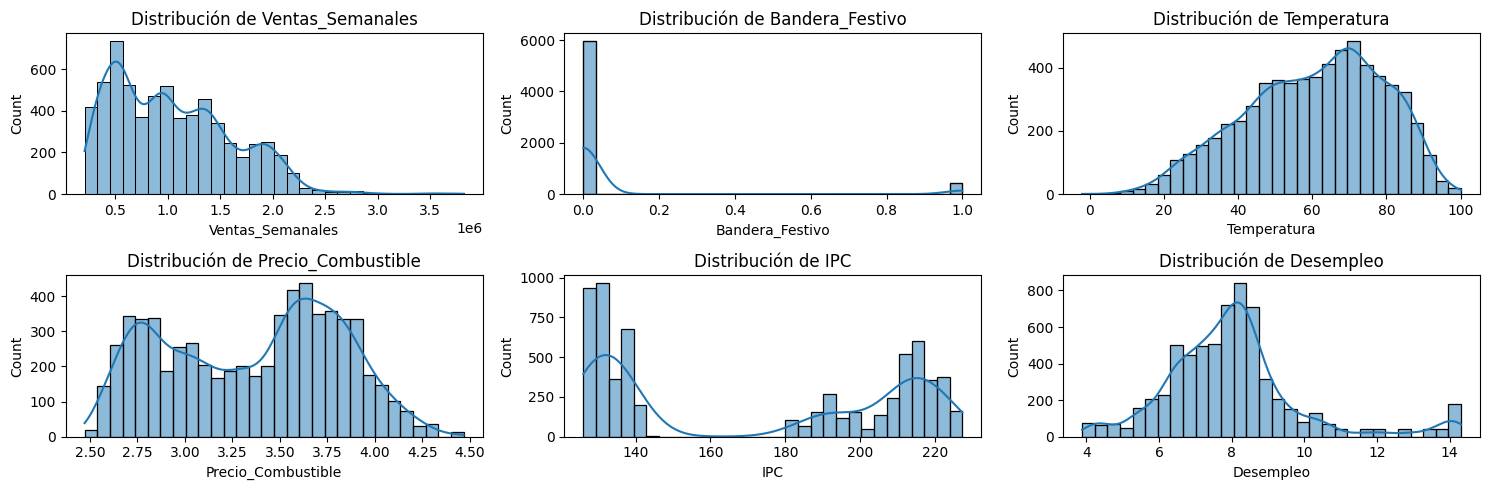

In [99]:
variables = ["Ventas_Semanales", "Bandera_Festivo", "Temperatura", "Precio_Combustible", "IPC", "Desempleo"]
plt.figure(figsize=(15, 5))
for i, variable in enumerate(variables, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[variable], kde=True, bins=30)
    plt.title(f'Distribución de {variable}')
    plt.tight_layout()
plt.show()


- Ventas_Semanales: Las ventas semanales parecen estar sesgadas a la derecha, lo que indica que la mayoría de las semanas tienen ventas por debajo del promedio, pero hay algunas semanas con ventas excepcionalmente altas. La mayoría de las ventas semanales están concentradas alrededor de valores menores a 1.5 millones, aunque hay un número significativo que se extiende hasta 3 millones.
- Bandera_Festivo:La mayoría de las semanas no son festivas, lo que se refleja en el pico pronunciado en 0. Hay un pequeño número de semanas festivas representadas por el pico cerca de 1.
- Temperatura: La distribución de la temperatura tiene una forma más o menos normal (campana) centrada alrededor de 60-70 grados. Esto sugiere que la mayoría de las temperaturas registradas durante el período de ventas están en este rango.
- Precio_Combustible: La distribución de la temperatura tiene una forma más o menos normal (campana) centrada alrededor de 60-70 grados.Esto sugiere que la mayoría de las temperaturas registradas durante el período de ventas están en este rango.
- IPC (Índice de Precios al Consumidor): La distribución del IPC muestra tres picos, lo que indica tres niveles comunes para el IPC durante el período. Los valores oscilan entre 140 y más de 220, con concentraciones notables alrededor de 140, 180 y un poco más de 210.
- Desempleo: La tasa de desempleo tiene un pico pronunciado alrededor del 8%. Hay una dispersión hacia tasas de desempleo más altas y más bajas, pero la mayoría de los valores están concentrados cerca del pico.

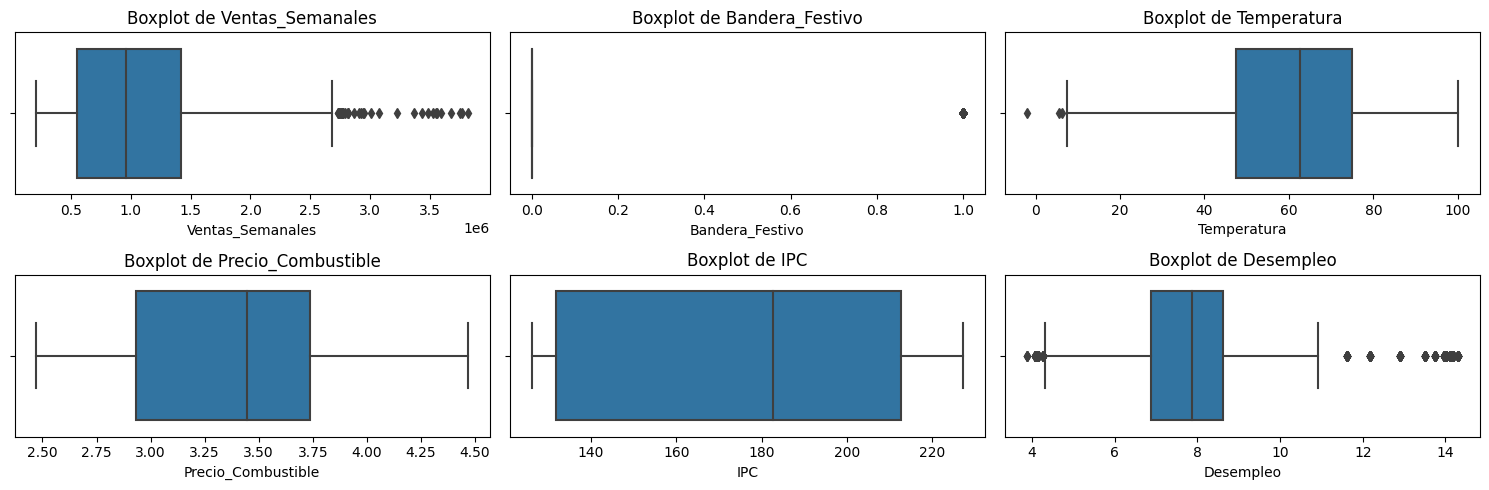

In [100]:
plt.figure(figsize=(15, 5))
for i, variable in enumerate(variables, 1):
    plt.subplot(2, 3, i)  # 2 filas, 3 columnas para 6 gráficos
    sns.boxplot(x=df[variable])
    plt.title(f'Boxplot de {variable}')
    plt.tight_layout()
plt.show()

- Ventas_Semanales: La mediana de las ventas semanales está por debajo de 1.5 millones. La mayoría de las ventas se encuentran concentradas entre valores cercanos a 0.5 y 2.5 millones (esto lo denotan los límites de la caja). Hay varios valores atípicos hacia la derecha, lo que indica semanas con ventas excepcionalmente altas en comparación con el promedio.
- Bandera_Festivo: Dado que esta es una variable binaria, el boxplot muestra un rango estrecho con un valor atípico. La mediana está en 0, confirmando que la mayoría de las semanas no son festivas. El valor atípico en 1 representa las semanas festivas.
- Temperatura: La temperatura tiene una distribución relativamente simétrica, con la mediana cerca del centro del rango. Sin embargo, hay algunos valores atípicos hacia la izquierda, indicando algunas semanas con temperaturas excepcionalmente bajas.
- Precio_Combustible: El precio del combustible tiene una distribución compacta, con la mayoría de los precios concentrados entre 2.75 y 4.25. No hay valores atípicos evidentes para esta variable.
- IPC (Índice de Precios al Consumidor): La mediana del IPC está cerca del centro del rango. La distribución es bastante simétrica, con la mayoría de los valores concentrados entre 140 y 220.
No hay valores atípicos evidentes para esta variable.
- Desempleo: La mediana de la tasa de desempleo está cerca de 8%. Hay varios valores atípicos hacia la izquierda, indicando periodos con tasas de desempleo más bajas de lo común.

Ahora se procede a graficar el promedio de las variables numéricas en el tiempo para ver sus tendencias.

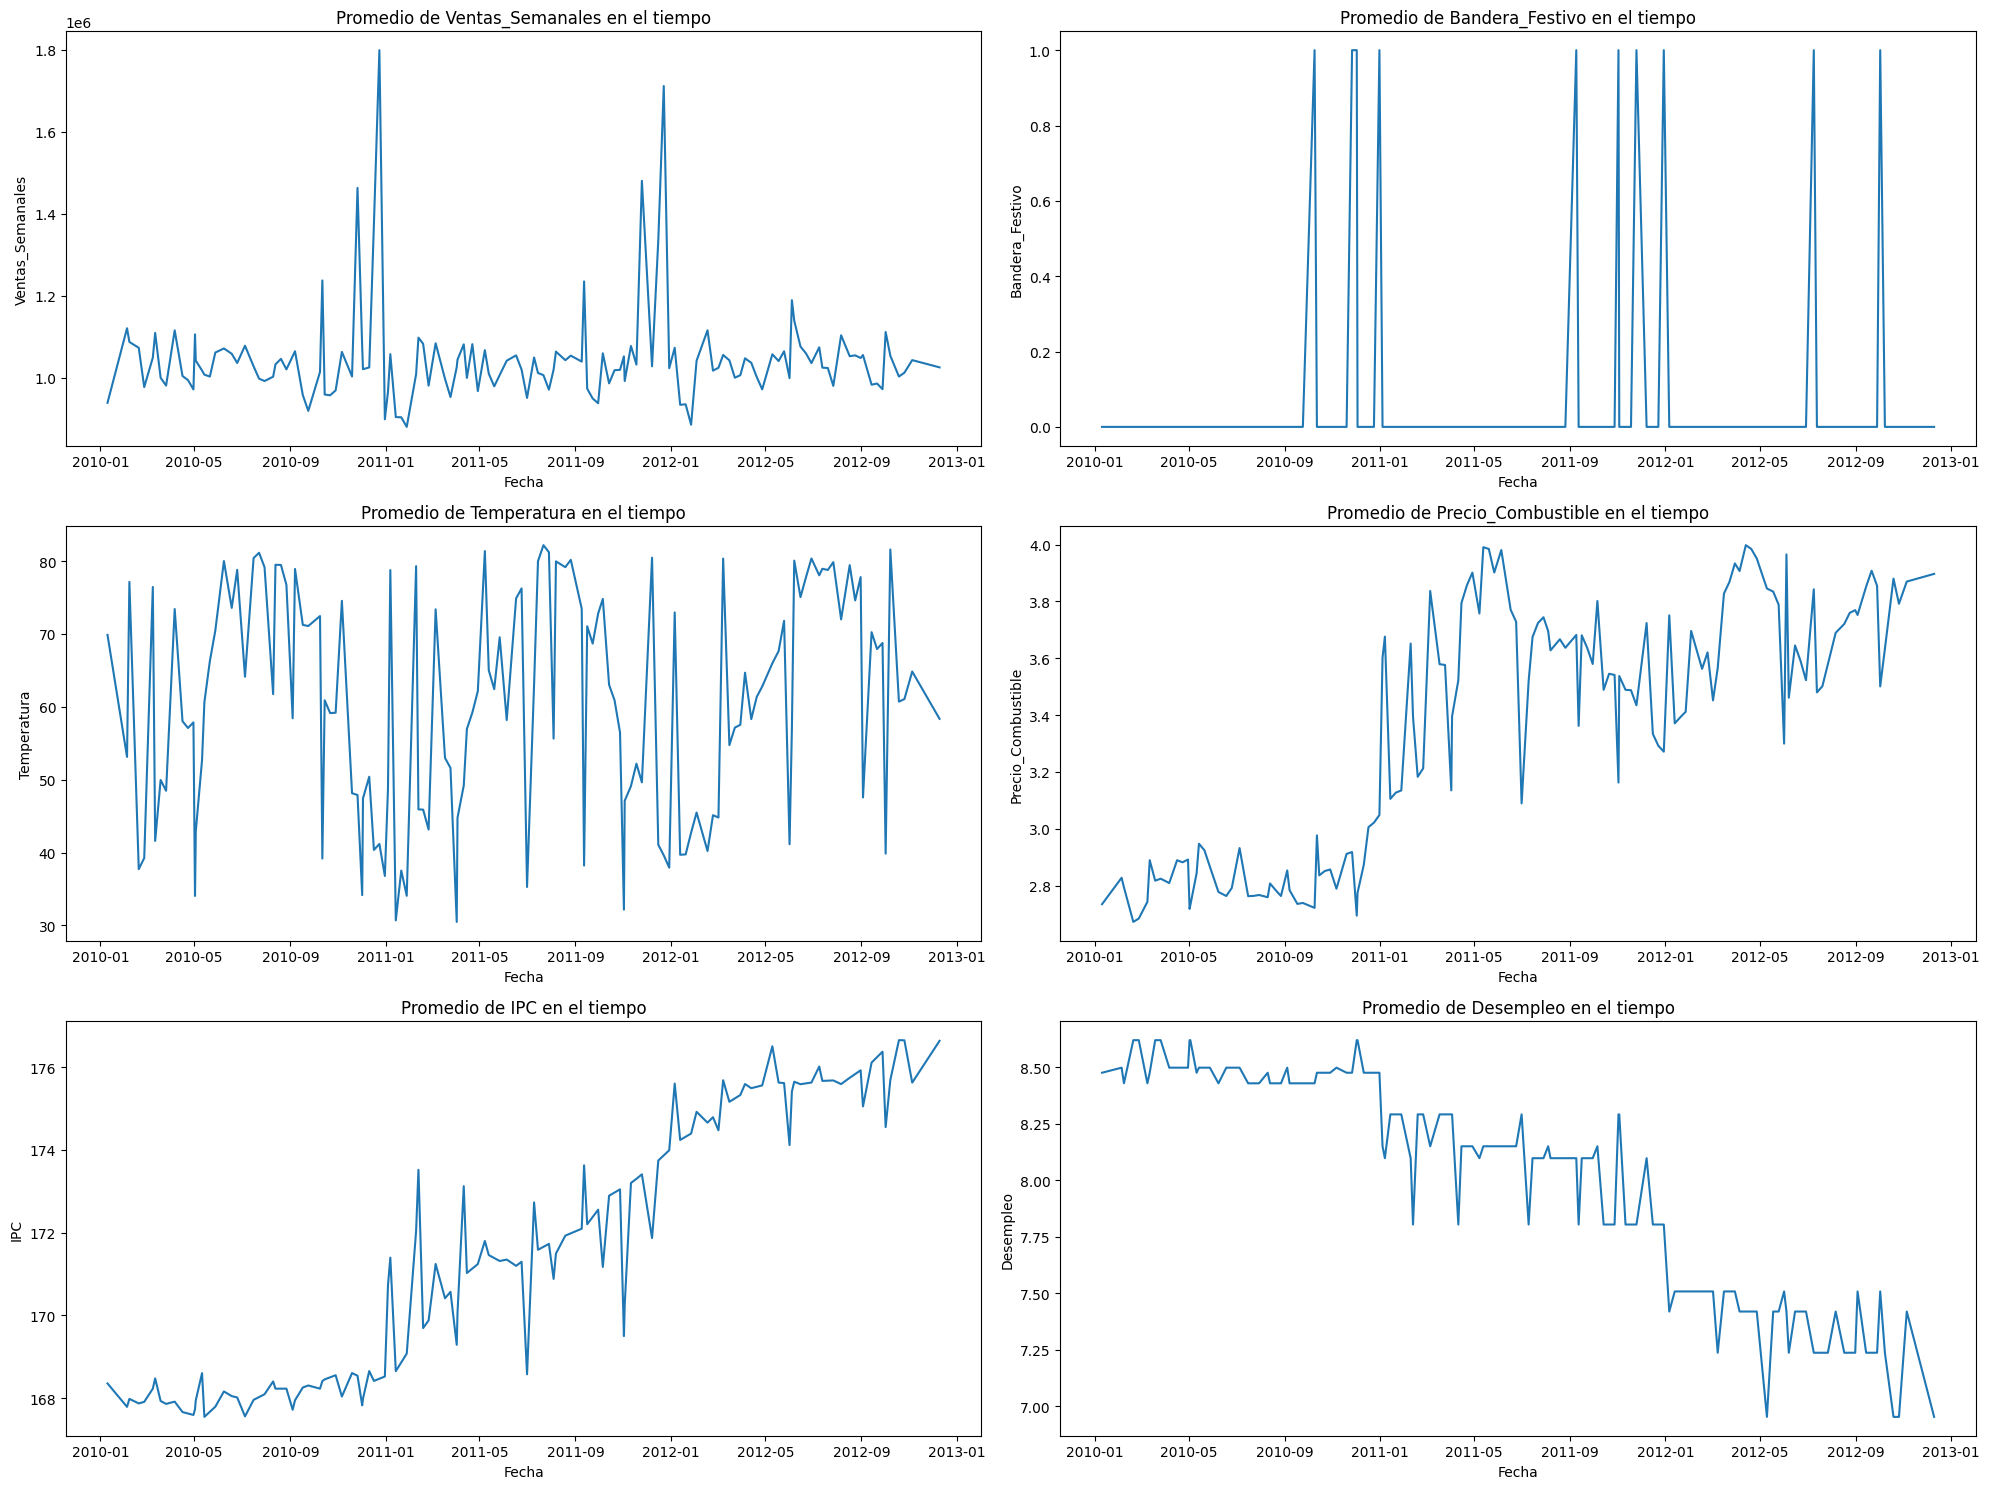

In [101]:
df['Fecha'] = pd.to_datetime(df['Fecha'])
df_avg = df.groupby('Fecha').mean().reset_index()
plt.figure(figsize=(20, 15))
for i, variable in enumerate(variables, 1):
    plt.subplot(3, 2, i)  # 2 filas, 3 columnas para 6 gráficos
    sns.lineplot(x="Fecha", y=variable, data=df_avg)
    plt.title(f'Promedio de {variable} en el tiempo')
    plt.tight_layout()

plt.show()


- Promedio de Ventas_Semanales en el tiempo: Se observan picos significativos en ciertos momentos, lo que puede corresponder a eventos especiales o períodos festivos, como Navidad o el Black Friday. Aparte de esos picos, las ventas parecen ser bastante estables a lo largo del tiempo, con ligeras fluctuaciones.
- Promedio de Bandera_Festivo en el tiempo: Como es de esperarse de una variable binaria que representa días festivos, vemos líneas verticales en las fechas donde ocurren festividades. Estas líneas representan que en ese período se tuvo un festivo.
- Promedio de Temperatura en el tiempo: Se observa una clara tendencia estacional, con temperaturas más altas en los meses de verano y más bajas en los meses de invierno. Esto tiene sentido dado que estamos observando datos de un país del hemisferio norte (EEUU).
- Promedio de Precio_Combustible en el tiempo: El precio del combustible parece tener una tendencia ascendente a lo largo del período observado, aunque con algunas fluctuaciones notables.
- Promedio de IPC (Índice de Precios al Consumidor) en el tiempo: El IPC muestra una tendencia ascendente a lo largo del tiempo. Esto indica que los precios generales estaban aumentando en este período.
- Promedio de Desempleo en el tiempo: La tasa de desempleo muestra una tendencia descendente en general, indicando una mejora en las condiciones del mercado laboral durante este período. Sin embargo, se observan algunas fluctuaciones en esta tendenc

### 3.4. Descripción y visualización de los datos categóricos

Dentro de nuestro conjunto de datos, la columna que representa la identificación de las tiendas es el principal atributo categórico. Dado que estas identificaciones representan diferentes tiendas, es esencial entender cómo se distribuyen nuestros datos en función de estas tiendas y asegurarnos de que la información sea consistente para cada una.

In [102]:
# Agrupando por 'Tienda' y calculando las estadísticas deseadas
resumen_tiendas = df.groupby('Tienda').agg(
    registros=('Fecha', 'size'),
    fecha_minima=('Fecha', 'min'),
    fecha_maxima=('Fecha', 'max'),
    ventas_semanales_promedio=('Ventas_Semanales', 'mean')
).reset_index()

print(resumen_tiendas)

    Tienda  registros fecha_minima fecha_maxima  ventas_semanales_promedio
0        1        143   2010-01-10   2012-12-10               1.555264e+06
1        2        143   2010-01-10   2012-12-10               1.925751e+06
2        3        143   2010-01-10   2012-12-10               4.027044e+05
3        4        143   2010-01-10   2012-12-10               2.094713e+06
4        5        143   2010-01-10   2012-12-10               3.180118e+05
5        6        143   2010-01-10   2012-12-10               1.564728e+06
6        7        143   2010-01-10   2012-12-10               5.706173e+05
7        8        143   2010-01-10   2012-12-10               9.087495e+05
8        9        143   2010-01-10   2012-12-10               5.439806e+05
9       10        143   2010-01-10   2012-12-10               1.899425e+06
10      11        143   2010-01-10   2012-12-10               1.356383e+06
11      12        143   2010-01-10   2012-12-10               1.009002e+06
12      13        143   2

 Todas las tiendas, desde el ID 1 hasta el 45, tienen un total de 143 registros, lo que indica que hay una consistencia en el número de registros por tienda. Las fechas varían desde el 10 de enero de 2010 hasta el 10 de diciembre de 2012, lo que muestra que se tienen datos a lo largo de casi tres años para cada tienda. En cuanto a las ventas semanales promedio, hay una amplia variación entre las tiendas. Por ejemplo, la tienda 1 tiene un promedio de ventas de aproximadamente 1.56 millones, mientras que la tienda 3 tiene alrededor de 403,000. Estas diferencias en las ventas promedio podrían deberse a factores como la ubicación, el tamaño o la clientela de cada tienda. Es interesante notar que mientras algunas tiendas tienen ventas promedio que superan el millón, otras tiendas tienen cifras considerablemente menores.

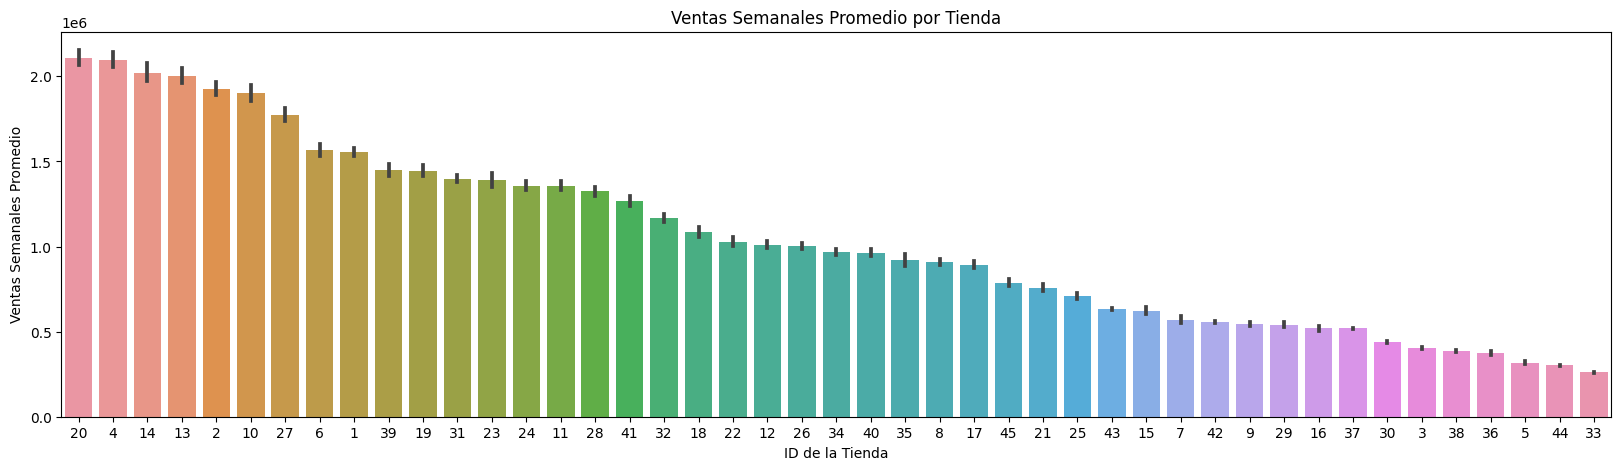

In [103]:
order = df.groupby('Tienda')['Ventas_Semanales'].mean().sort_values(ascending=False).index
plt.figure(figsize=(20, 5))
sns.barplot(data=df, x="Tienda", y="Ventas_Semanales", order=order)
plt.title("Ventas Semanales Promedio por Tienda")
plt.ylabel("Ventas Semanales Promedio")
plt.xlabel("ID de la Tienda")
plt.show()



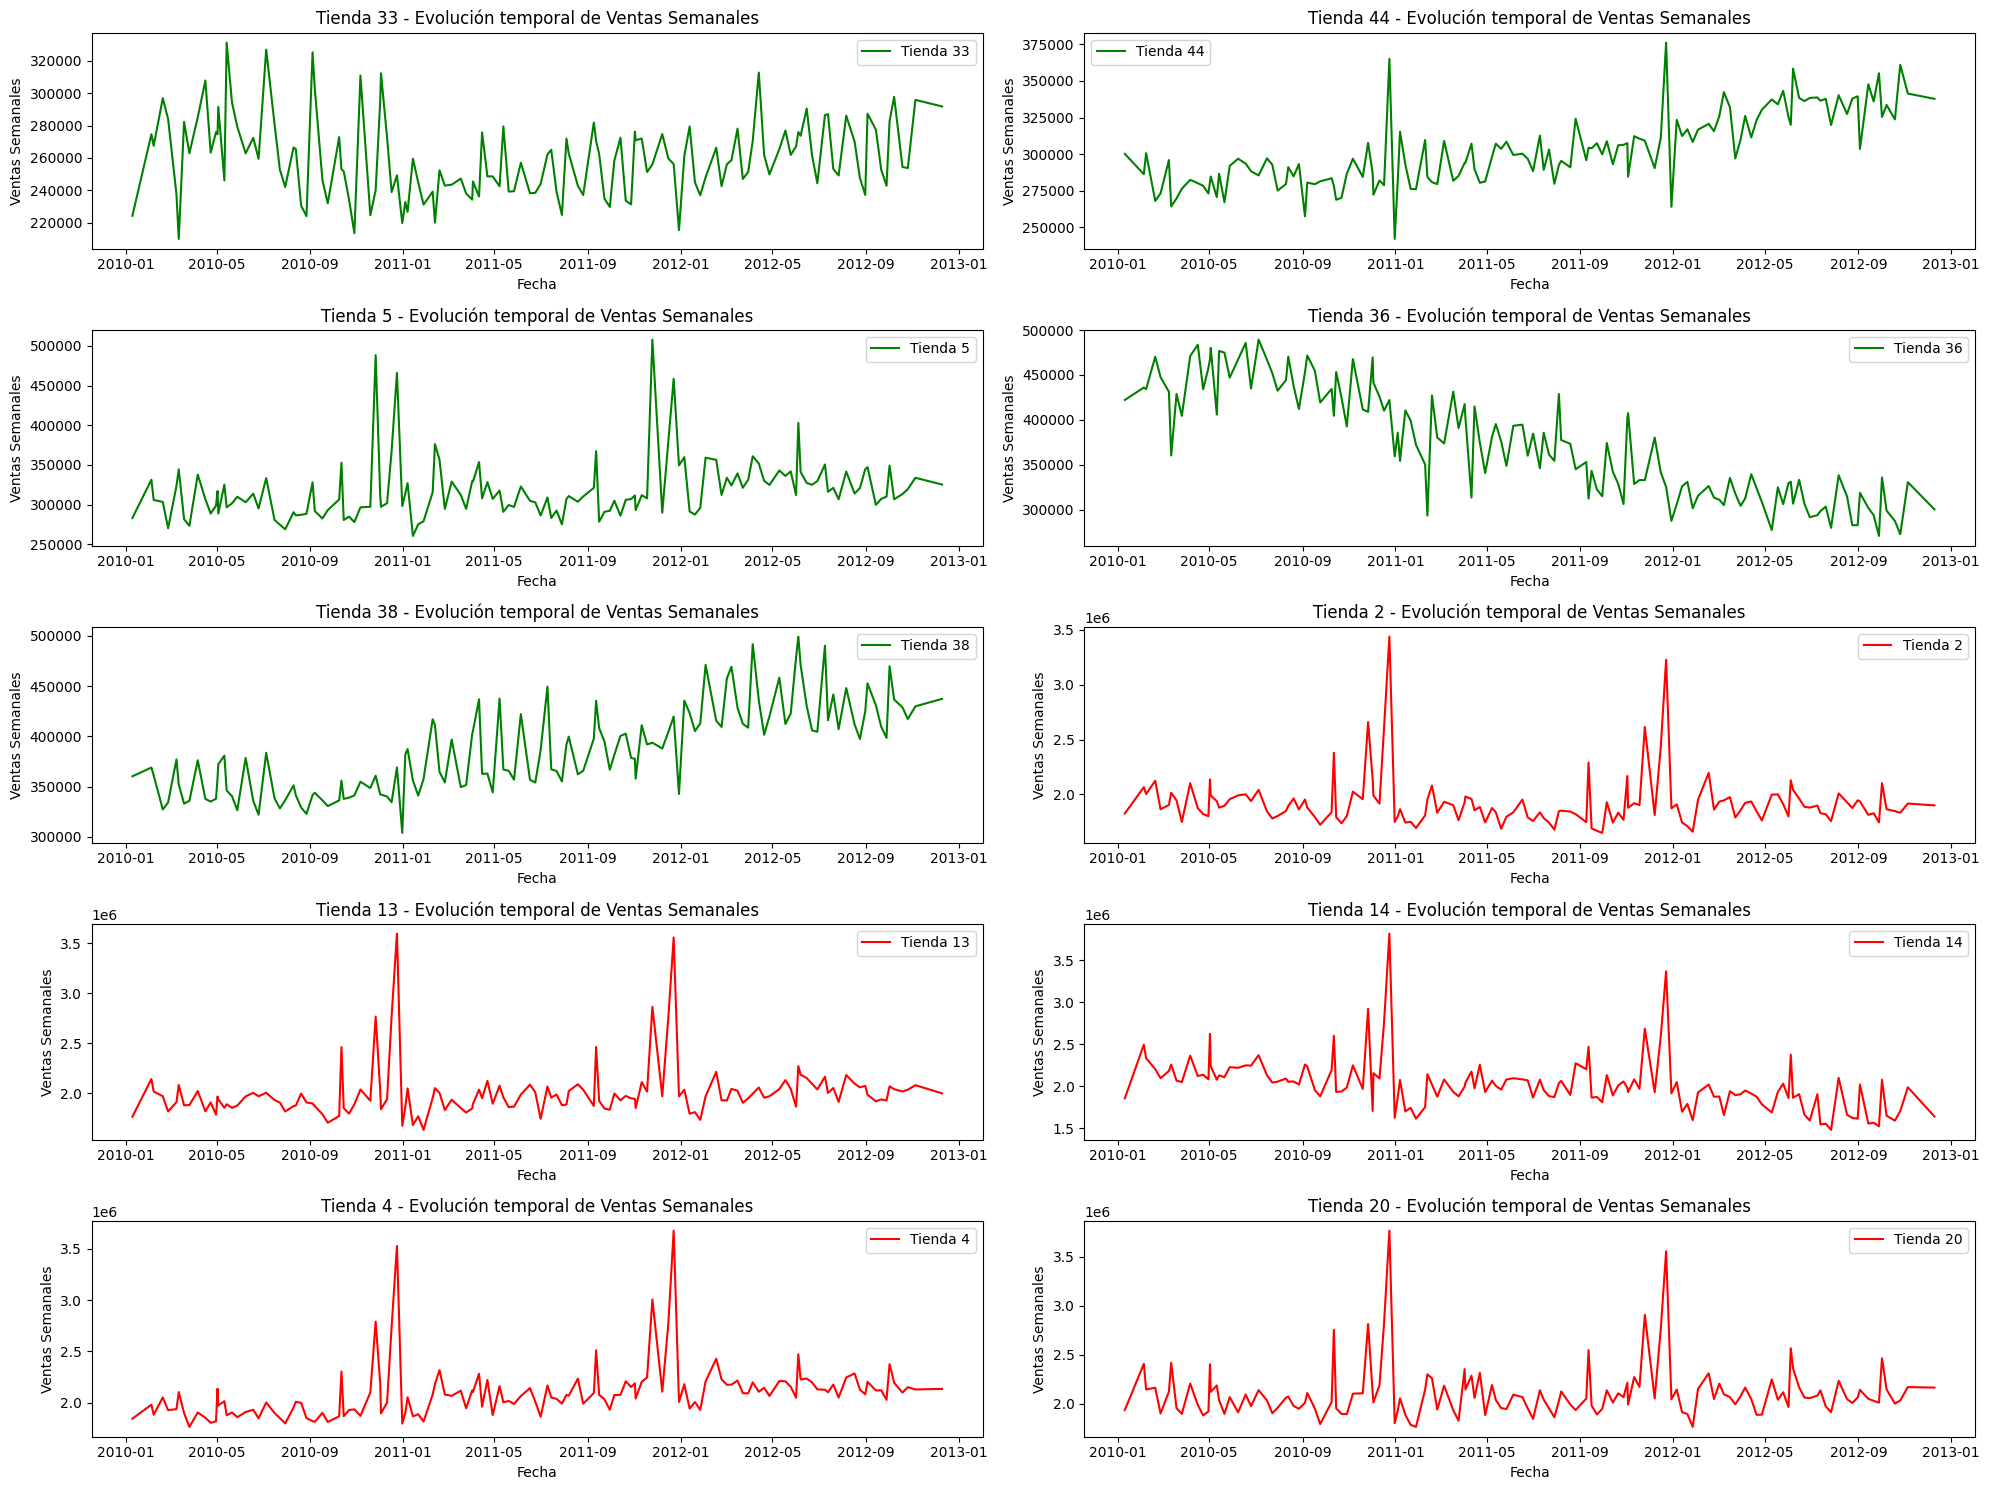

In [104]:
avg_sales = df.groupby('Tienda')['Ventas_Semanales'].mean().sort_values()
top_5_lowest = avg_sales.head(5).index
top_5_highest = avg_sales.tail(5).index
selected_stores = list(top_5_lowest) + list(top_5_highest)
plt.figure(figsize=(20, 15))
colors = ['green'] * 5 + ['red'] * 5
for idx, (store, color) in enumerate(zip(selected_stores, colors), 1):
    plt.subplot(5, 2, idx)
    data = df[df['Tienda'] == store]
    sns.lineplot(data=data, x='Fecha', y='Ventas_Semanales', label=f"Tienda {store}", color=color)
    plt.title(f"Tienda {store} - Evolución temporal de Ventas Semanales")
    plt.xlabel("Fecha")
    plt.ylabel("Ventas Semanales")
    plt.tight_layout()

plt.show()



- Tiendas con menores ventas (Verde): Tienda 33, 5, 38, 44 y 36: Estas tiendas muestran variaciones semanales en sus ventas, con ciertos picos que podrían coincidir con eventos específicos, promociones o festividades. Sin embargo, en general, sus valores se mantienen relativamente bajos en comparación con las tiendas de alto rendimiento.

- Tiendas con mayores ventas (Rojo): Tienda 2, 14, 20, 4 y 13: Las tiendas con las ventas más altas exhiben una tendencia similar, con fluctuaciones significativas a lo largo del tiempo. Es notable que estos picos son más pronunciados, lo que indica períodos de ventas extremadamente altas. Las tiendas 2, 14, 4 y 20, en particular, muestran algunos picos prominentes que podrían indicar eventos promocionales o festividades específicas que generan un aumento sustancial en las ventas.

### 3.5. Tratamiento de datos perdidos o vacíos

In [105]:
df.isna().sum()

Tienda                0
Fecha                 0
Ventas_Semanales      0
Bandera_Festivo       0
Temperatura           0
Precio_Combustible    0
IPC                   0
Desempleo             0
dtype: int64

La base no tiene datos perdidos o vacíos por lo que no aplica tratamiento alguno.

### 3.6 Tratamiento de outliers

- Ventas_Semanales: Observamos varios outliers en la parte superior del boxplot.
- Temperatura: Hay algunos valores bajos que se desvían de la distribución principal, pero no parecen ser outliers extremos.
- Precio_Combustible: No hay outliers visibles y la distribución parece razonablemente simétrica.
- IPC: La distribución es ligeramente asimétrica hacia la izquierda, pero no hay outliers visibles.
- Desempleo: Observamos varios outliers en la parte baja del boxplot.

Después de un análisis detallado de los datos, se ha decidido no tratar los outliers identificados en la variable "Ventas_Semanales". Esta decisión se basa en la comprensión de que estos valores atípicos no son errores o anomalías, sino representaciones genuinas de variaciones en las ventas a lo largo del tiempo. 

También se decidido no intervenir en los outliers identificados en la variable "Desempleo". Es esencial entender que estos valores atípicos reflejan posiblemente situaciones económicas reales y excepcionales que pueden tener un impacto significativo en las ventas. Eliminar o ajustar estos datos podría resultar en una pérdida de información valiosa que es vital para comprender las correlaciones y tendencias subyacentes.

### 3.7 Objetivo de Modelado y Transformación de los Datos

Una vez visualizados los datos, el objetivo será predecir las ventas totales por semana de Walmart.Para ello, consideraremos las series temporales como nuestra herramienta principal. Las series temporales nos permiten analizar patrones de tiempo y prever futuras tendencias basadas en la información histórica.

Dado que las ventas de Walmart podrían ser influenciadas por una serie de factores externos, como festivos, temperatura, precio del combustible, IPC y tasa de desempleo, nuestro modelo debe tener en cuenta estas variables para ofrecer predicciones precisas. Es esencial resaltar que el enfoque principal está en el comportamiento temporal de las ventas, y cómo este comportamiento puede ser modulado por las otras características.

Para abordar este problema, se realizarán las siguientes transformaciones en los datos:

- Fechas: Convertiremos la columna de fechas en un índice de series temporales para facilitar análisis en función del tiempo.
- Variables categóricas: Aunque la base de datos no tiene muchas variables categóricas, la variable "Bandera_Festivo" ya está en un formato adecuado para el análisis, indicando si una semana es festiva o no.
- Descomposición de series temporales: Descompondremos las ventas semanales en tendencia, estacionalidad y residuos. Esto nos permitirá comprender y modelar cada componente por separado.
- Lag y variables derivadas: Introduciremos retardos (lags) y otras variables derivadas de las ventas semanales y otras variables, ya que los patrones anteriores pueden influir en las ventas futuras.
- Normalización de datos: Las variables con diferentes escalas pueden ser problemáticas para ciertos modelos. Por lo tanto, normalizaremos las variables para que todas estén en la misma escala.

#### 3.7.1. Crear un nuevo DF

A partir de los datos originales, se creará una tabla que contenga lo siguiente:
- Fecha
- Suma de las Ventas Semanales de todos los locales
- Si la semana fue festiva o no (Bandera_Festivo)
- Promedio de la Temperatura de cada semana entre todas las tiendas.
- Promedio del Precio_Combustible
- Promedio de IPC
- Promedio de Desempleo

In [106]:
datos = df.groupby('Fecha').agg({
    'Ventas_Semanales': 'sum',
    'Bandera_Festivo': 'max',
    'Temperatura': 'mean',
    'Precio_Combustible': 'mean',
    'IPC': 'mean',
    'Desempleo': 'mean'
}).reset_index()

In [107]:
datos

,Fecha,Ventas_Semanales,Bandera_Festivo,Temperatura,Precio_Combustible,IPC,Desempleo
0,2010-01-10,42239875.87,0,69.868000,2.734333,168.354706,8.475289
1,2010-02-04,50423831.26,0,53.120889,2.827333,167.789036,8.497711
2,2010-02-07,48917484.50,0,77.133333,2.793511,167.982101,8.428578
3,2010-02-19,48276993.78,0,37.719778,2.672067,167.871686,8.619311
4,2010-02-26,43968571.13,0,39.243556,2.683933,167.909657,8.619311
...,...,...,...,...,...,...,...
138,2012-10-08,47403451.04,0,81.580222,3.632911,175.689620,7.237333
139,2012-10-19,45122410.57,0,60.705333,3.880000,176.652613,6.953711
140,2012-10-26,45544116.29,0,61.051111,3.791489,176.649482,6.953711
141,2012-11-05,46925878.99,0,64.838000,3.869689,175.626366,7.419533


In [108]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Fecha               143 non-null    datetime64[ns]
 1   Ventas_Semanales    143 non-null    float64       
 2   Bandera_Festivo     143 non-null    int64         
 3   Temperatura         143 non-null    float64       
 4   Precio_Combustible  143 non-null    float64       
 5   IPC                 143 non-null    float64       
 6   Desempleo           143 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 7.9 KB


Se realizará el análisis con información de 143 semanas.

In [109]:
datos.describe()

,Ventas_Semanales,Bandera_Festivo,Temperatura,Precio_Combustible,IPC,Desempleo
count,1.430000e+02,143.000000,143.000000,143.000000,143.000000,143.000000
mean,4.711342e+07,0.069930,60.663782,3.358607,171.578394,7.999151
std,5.444206e+06,0.255926,15.172792,0.429401,3.100148,0.483853
min,3.959985e+07,0.000000,30.480889,2.672067,167.546485,6.953711
25%,4.488059e+07,0.000000,47.720222,2.885367,168.408144,7.508333
50%,4.624390e+07,0.000000,61.051111,3.488644,171.386189,8.150133
75%,4.779202e+07,0.000000,74.697333,3.726133,174.724576,8.428578
max,8.093142e+07,1.000000,82.176444,3.997778,176.652613,8.619311


 Las ventas semanales varían entre aproximadamente 39.6 millones y 81 millones con un promedio cercano a 47.1 millones. Alrededor del 7% de las entradas son festivas. La temperatura promedio es de 60.66 grados con un mínimo de 30.48 y un máximo de 82.18. El precio promedio del combustible es de 3.36, el IPC promedio es de 171.58 y la tasa de desempleo promedio es del 8%.

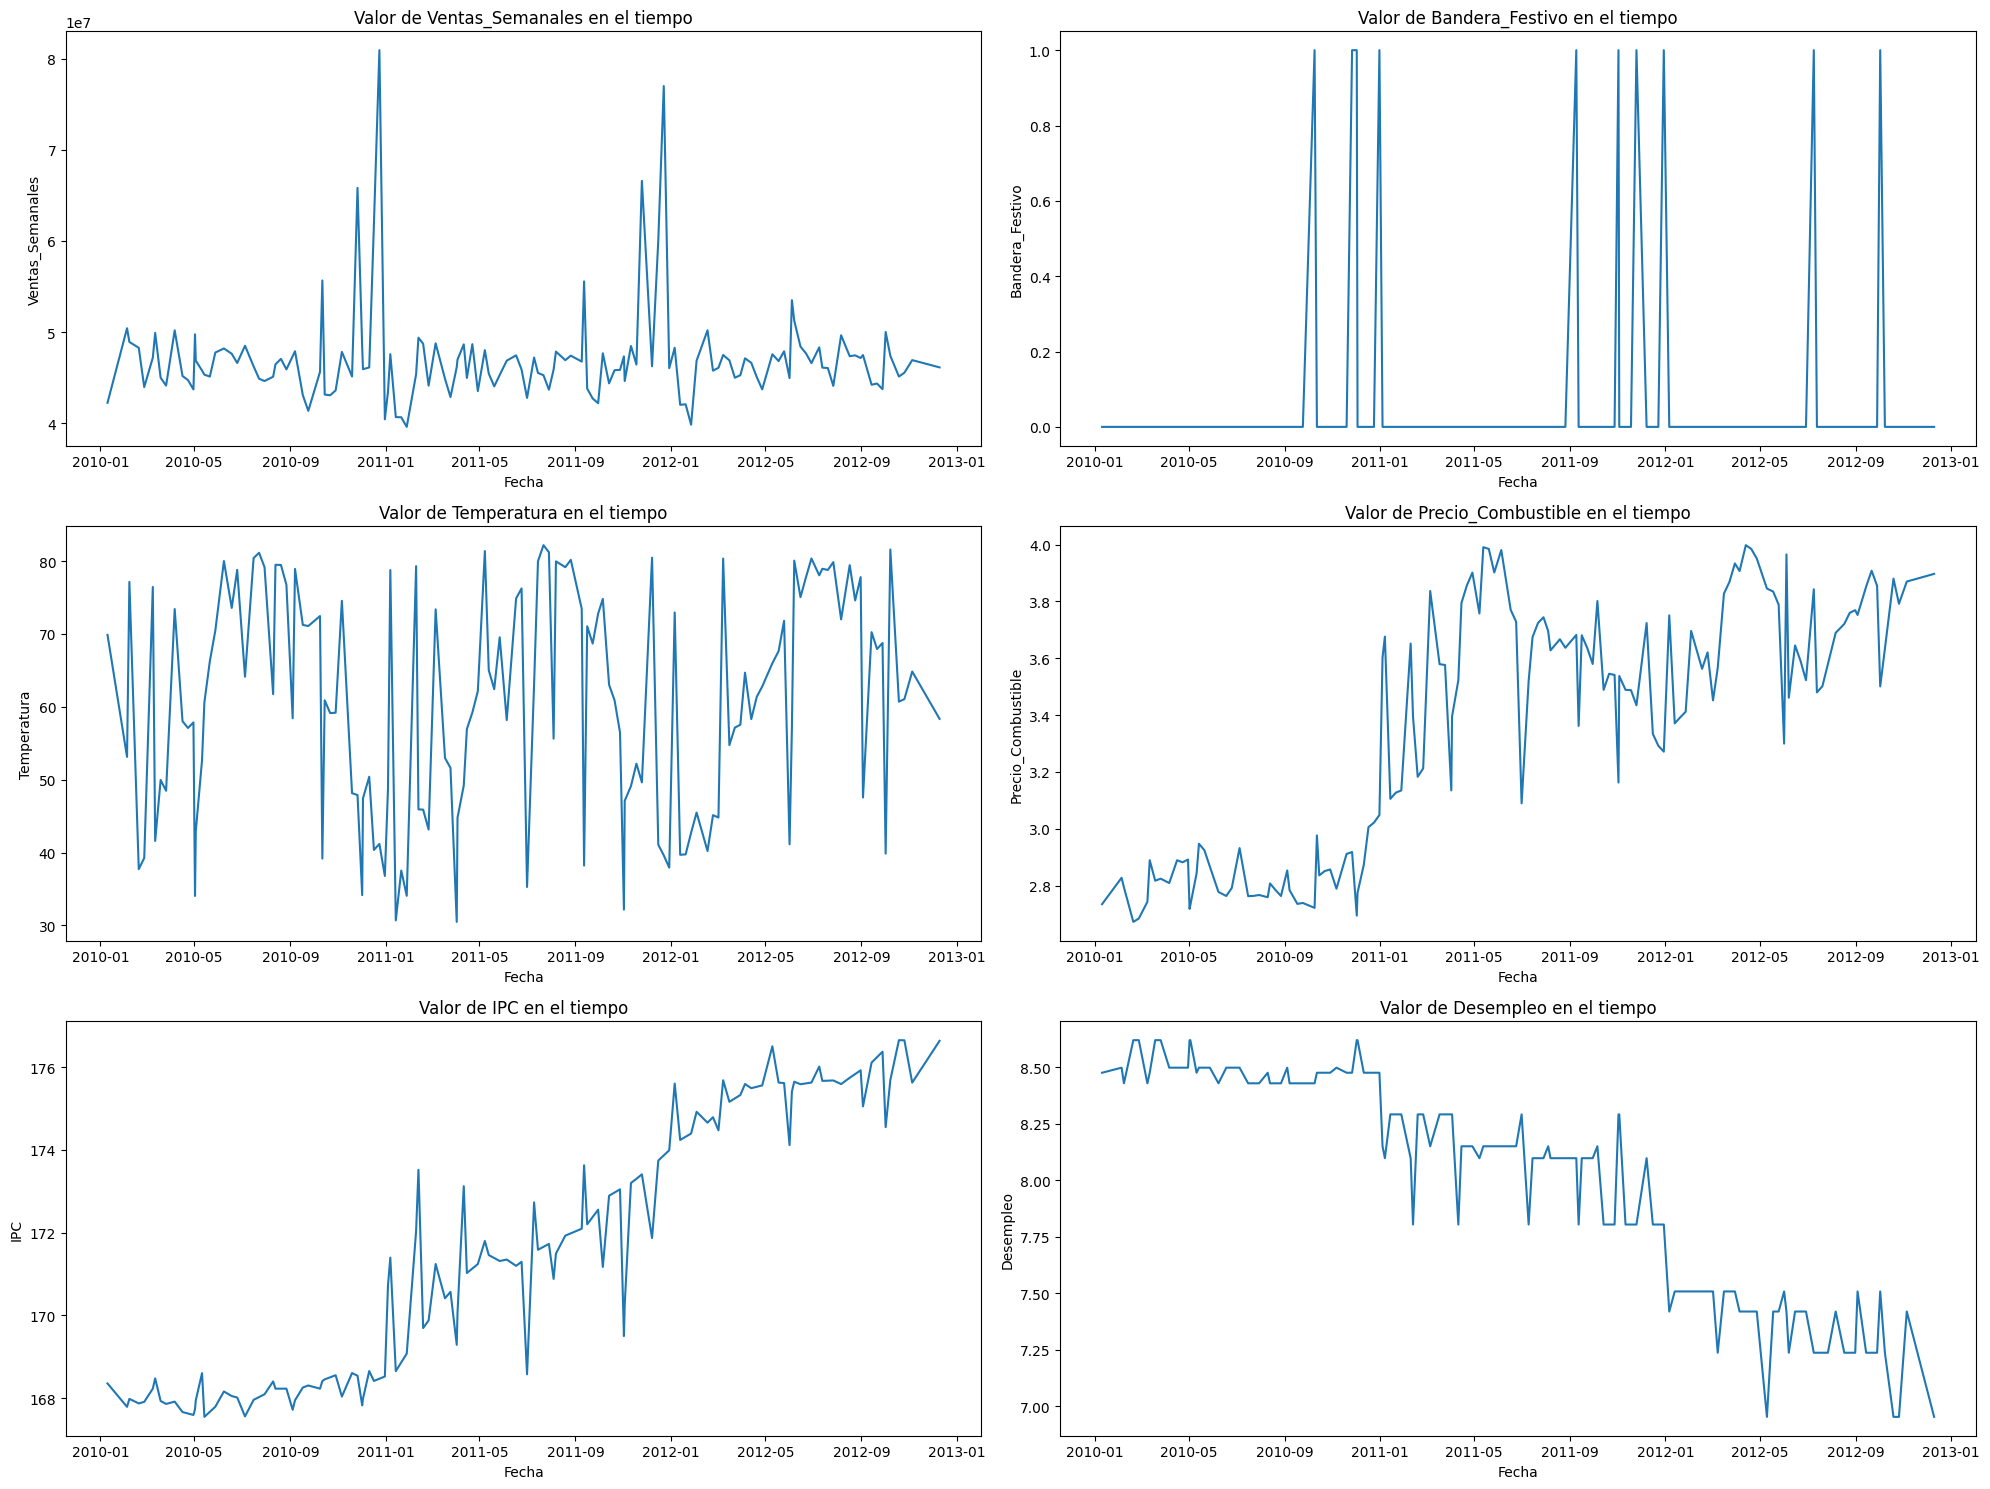

In [110]:
columnas = ["Ventas_Semanales","Bandera_Festivo","Temperatura","Precio_Combustible","IPC","Desempleo"]

plt.figure(figsize=(20, 15))
for i, columna in enumerate(columnas, 1):
    plt.subplot(3, 2, i)  # 2 filas, 3 columnas para 6 gráficos
    sns.lineplot(x="Fecha", y=columna, data=datos)
    plt.title(f'Valor de {columna} en el tiempo')
    plt.tight_layout()

plt.show()

## 4. Correlación de las Variables

                    Ventas_Semanales  Bandera_Festivo  Temperatura  \
Ventas_Semanales            1.000000         0.172683    -0.159160   
Bandera_Festivo             0.172683         1.000000    -0.189186   
Temperatura                -0.159160        -0.189186     1.000000   
Precio_Combustible         -0.056722        -0.084039     0.205757   
IPC                         0.023413        -0.027542     0.159457   
Desempleo                   0.003524         0.042639    -0.168460   

                    Precio_Combustible       IPC  Desempleo  
Ventas_Semanales             -0.056722  0.023413   0.003524  
Bandera_Festivo              -0.084039 -0.027542   0.042639  
Temperatura                   0.205757  0.159457  -0.168460  
Precio_Combustible            1.000000  0.824704  -0.747205  
IPC                           0.824704  1.000000  -0.977430  
Desempleo                    -0.747205 -0.977430   1.000000  


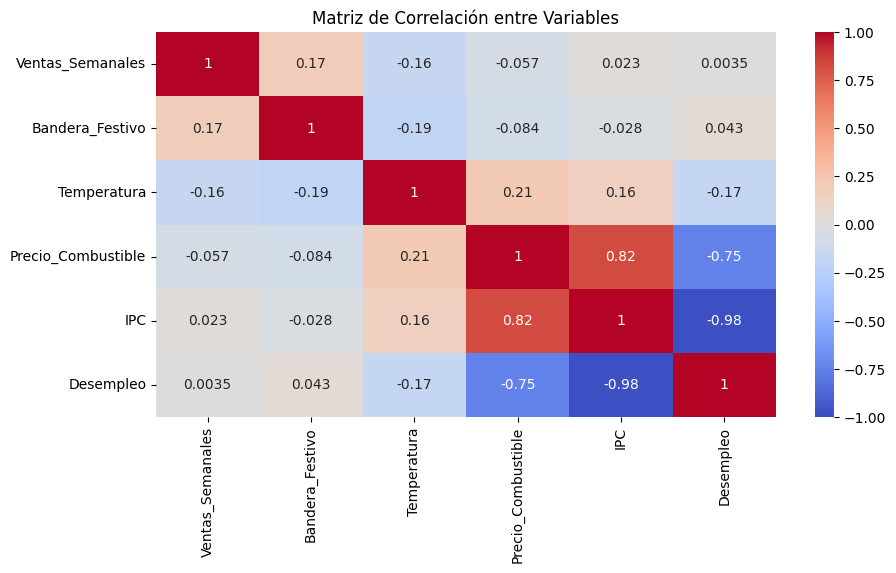

In [111]:
correlacion = datos.corr()
print(correlacion)
plt.figure(figsize=(10, 5))
sns.heatmap(correlacion, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matriz de Correlación entre Variables")
plt.show()

Las ventas semanales tienen una correlación positiva moderada con la bandera festiva (0.172683), lo que indica que hay una tendencia a que las ventas sean mayores durante las semanas que son festivas. Por otro lado, las ventas semanales tienen una correlación negativa, aunque leve, con la temperatura (-0.159160), lo que sugiere que las ventas tienden a disminuir ligeramente a medida que las temperaturas aumentan. Con respecto al precio del combustible y el IPC, las correlaciones con las ventas semanales son muy bajas, siendo -0.056722 y 0.023413 respectivamente, lo que indica que estos factores no tienen una relación fuerte con las ventas semanales en el conjunto de datos proporcionado. Finalmente, la correlación entre las ventas semanales y el desempleo es prácticamente nula (0.003524), lo que implica que la tasa de desempleo no tiene un impacto discernible en las ventas semanales

## 5. Selección de Variables

### 5.1. Variable Dependente

Ventas_Semanales: Esta es nuestra variable objetivo, que queremos predecir. Representa la suma de las ventas semanales de todos los locales de Walmart.

### 5.2. Variables Independentes

En un inicio se considerará:

- Bandera_Festivo: Variable binaria que indica si una semana es festiva (1) o no (0). Se espera que las festividades puedan tener un impacto en las ventas debido a eventos promocionales, compras de regalos, entre otros.
- Temperatura: Esta variable indica el promedio semanal de la temperatura. Las condiciones climáticas pueden influir en el comportamiento de compra de los consumidores. Por ejemplo, temperaturas extremadamente bajas o altas pueden reducir el tráfico en la tienda.
- Precio_Combustible: Refleja el costo promedio del combustible. Variaciones en el precio del combustible pueden afectar el poder adquisitivo de los consumidores y, por ende, sus decisiones de compra.
- IPC (Índice de Precios al Consumidor): Es una medida que examina el peso promediado de los precios de bienes y servicios. Un IPC más alto podría indicar una mayor inflación y podría tener un impacto en las ventas de Walmart.
- Desempleo: Representa la tasa promedio de desempleo. Una tasa de desempleo más alta podría indicar una economía más débil, lo que podría afectar negativamente las ventas.

Las variables independientes del modelo cambiarán en función de los ajustes en el modelo a elegir.

## 6. Selección de Modelo de Series de Tiempo: AR, MA, SARIMAX

### 6.1. Modelo de Serie de Tiempo (únicamente Ventas_Semanales en el Tiempo)

##### 6.1.1. Modelo Aditivo

In [112]:
from statsmodels.tsa.seasonal import seasonal_decompose
datos = datos.set_index(datos["Fecha"])
datos.drop(columns=["Fecha"])

,Ventas_Semanales,Bandera_Festivo,Temperatura,Precio_Combustible,IPC,Desempleo
Fecha,,,,,,
2010-01-10,42239875.87,0,69.868000,2.734333,168.354706,8.475289
2010-02-04,50423831.26,0,53.120889,2.827333,167.789036,8.497711
2010-02-07,48917484.50,0,77.133333,2.793511,167.982101,8.428578
2010-02-19,48276993.78,0,37.719778,2.672067,167.871686,8.619311
2010-02-26,43968571.13,0,39.243556,2.683933,167.909657,8.619311
...,...,...,...,...,...,...
2012-10-08,47403451.04,0,81.580222,3.632911,175.689620,7.237333
2012-10-19,45122410.57,0,60.705333,3.880000,176.652613,6.953711
2012-10-26,45544116.29,0,61.051111,3.791489,176.649482,6.953711


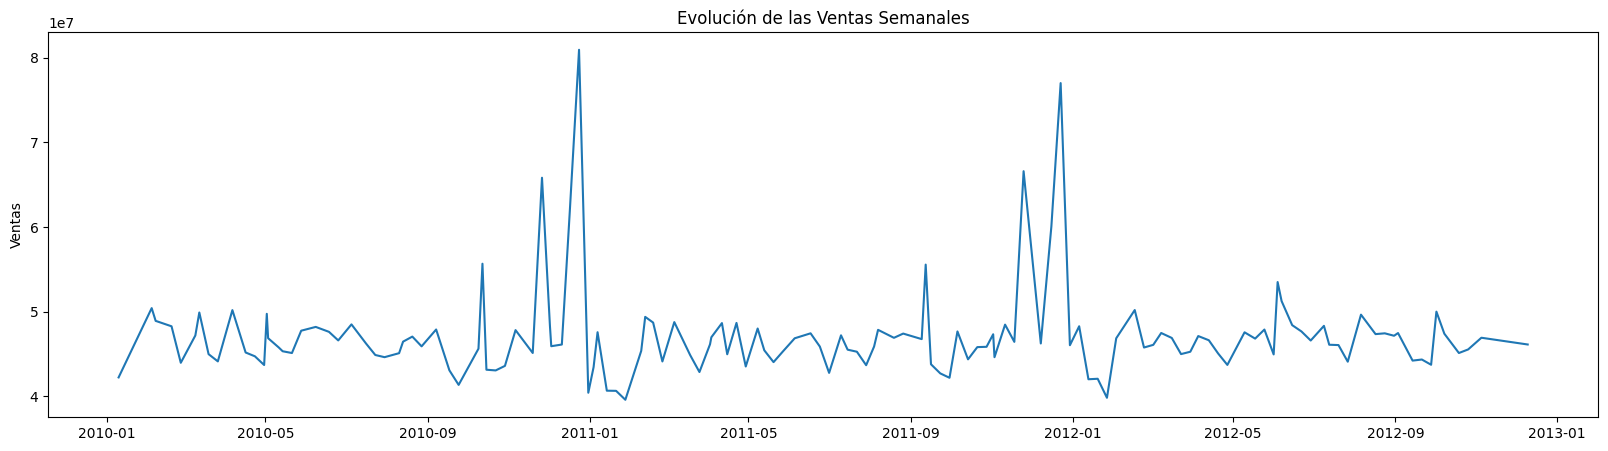

In [113]:
plt.figure(figsize=(20,5))
plt.plot(datos.Ventas_Semanales)
plt.title("Evolución de las Ventas Semanales")
plt.ylabel("Ventas")
plt.show()

Basándonos en lo que podemos observar en este gráfico, parece más adecuado un modelo aditivo porque las amplitudes de las fluctuaciones parecen ser consistentes a lo largo del tiempo. Sin embargo, es importante notar que esta es una interpretación visual, y para una decisión final es útil probar ambos modelos (aditivo y multiplicativo) y comparar su ajuste.

***PERIODO***: 52
1. Gráficos


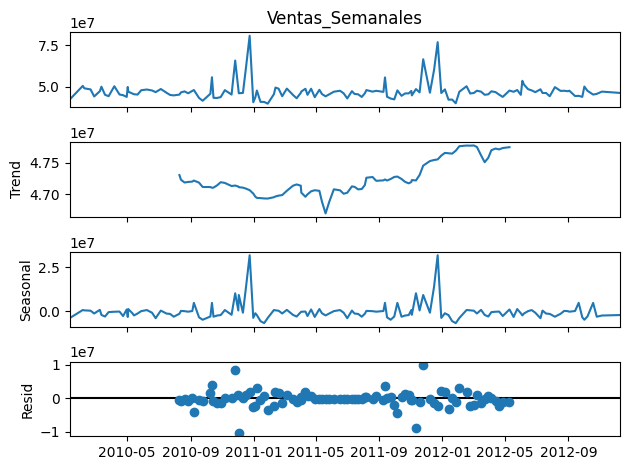



2. Extracción de los componentes
Vacíos en Tendencia: 52


3.Prueba de Dickey Fuller
ADF Statistic -3.7243932572387988
p-value 0.0037828344864995187
Critical Values:
	1%: -3.516
	5%: -2.899
	10%: -2.587


4.Análisis de Residuos


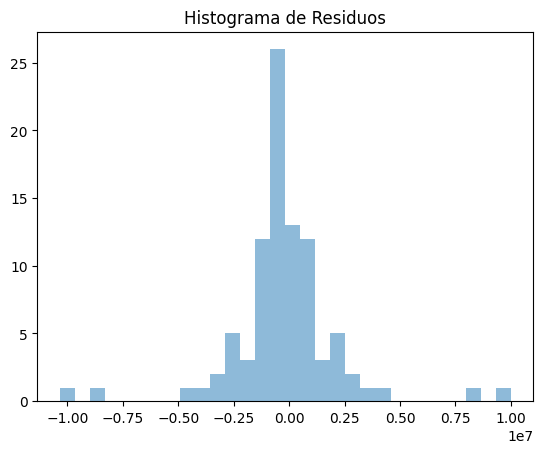

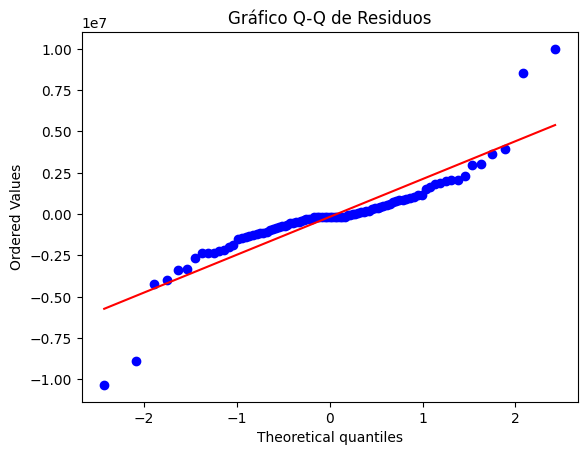

5.Comparación de Error Cuadrático Medio (MSE)
MSE: 6195117698304.853


In [114]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

print("***PERIODO***:",52)
print("1. Gráficos")
res_aditivo = sm.tsa.seasonal_decompose(datos.Ventas_Semanales, model="additive", period=52)
fig = res_aditivo.plot()
plt.show()
print("\n")
print("2. Extracción de los componentes")
tendencia = res_aditivo.trend
estacional = res_aditivo.seasonal
residuo = res_aditivo.resid
print("Vacíos en Tendencia:",tendencia.isna().sum())
print("\n")
print("3.Prueba de Dickey Fuller")
x = residuo.dropna()
resultado = adfuller(x)
print("ADF Statistic",resultado[0])
print("p-value",resultado[1])
print("Critical Values:")
for key, value in resultado[4].items():
    print('\t%s: %.3f' % (key, value))
print("\n")
print("4.Análisis de Residuos")
plt.hist(residuo.dropna(),bins=30,alpha=0.5)
plt.title("Histograma de Residuos")
plt.show()
stats.probplot(residuo.dropna(), plot=plt)
plt.title('Gráfico Q-Q de Residuos')
plt.show()
print("5.Comparación de Error Cuadrático Medio (MSE)")
mse = mean_squared_error(residuo.dropna(), [0]*len(residuo.dropna()))
print("MSE:", mse)



El periodo de 52 semanas tiene el menor MSE (6195117698304.853), lo que indica que la descomposición con un periodo de 52 semanas ha capturado mejor la estructura subyacente de la serie temporal en comparación con los otros periodos. El ADF Statistic es -3.724, que es menor que todos los valores críticos dados (1%, 5% y 10%). El valor p es 0.00378, que es menor que 0.05. Dado que el ADF Statistic es menor que los valores críticos y el valor p es significativo (menor que 0.05), podemos rechazar la hipótesis nula y concluir que la serie temporal es estacionaria.

##### 6.1.2. Modelo Multiplicativo

***PERIODO***: 52
1. Gráficos


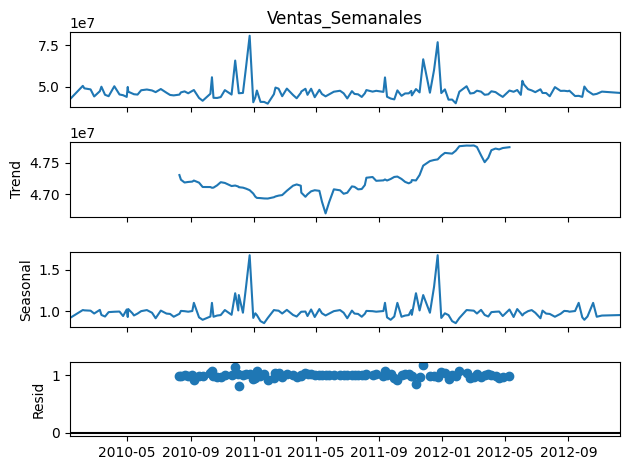



2. Extracción de los componentes
Vacíos en Tendencia: 52


3.Prueba de Dickey Fuller
ADF Statistic -7.453199744408313
p-value 5.5998413499346494e-11
Critical Values:
	1%: -3.508
	5%: -2.895
	10%: -2.585


4.Análisis de Residuos


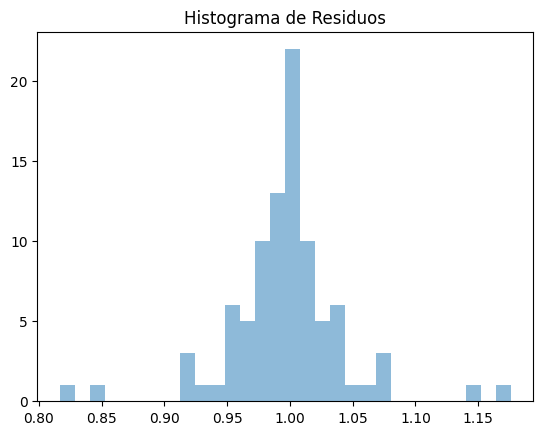

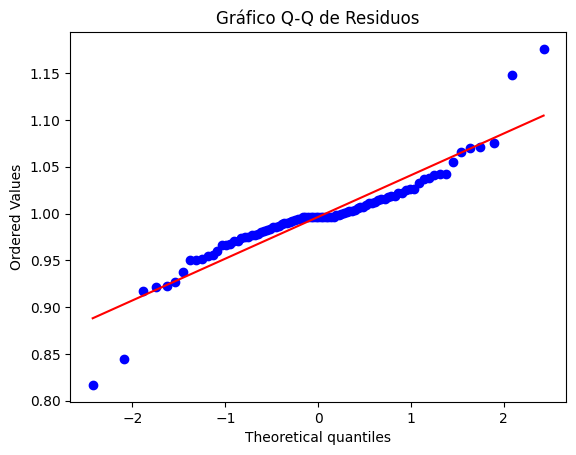

5.Comparación de Error Cuadrático Medio (MSE)
MSE: 0.9949904056477884


In [115]:
print("***PERIODO***:",52)
print("1. Gráficos")
res_aditivo = sm.tsa.seasonal_decompose(datos.Ventas_Semanales, model="multiplicative", period=52)
fig = res_aditivo.plot()
plt.show()
print("\n")
print("2. Extracción de los componentes")
tendencia = res_aditivo.trend
estacional = res_aditivo.seasonal
residuo = res_aditivo.resid
print("Vacíos en Tendencia:",tendencia.isna().sum())
print("\n")
print("3.Prueba de Dickey Fuller")
x = residuo.dropna()
resultado = adfuller(x)
print("ADF Statistic",resultado[0])
print("p-value",resultado[1])
print("Critical Values:")
for key, value in resultado[4].items():
    print('\t%s: %.3f' % (key, value))
print("\n")
print("4.Análisis de Residuos")
plt.hist(residuo.dropna(),bins=30,alpha=0.5)
plt.title("Histograma de Residuos")
plt.show()
stats.probplot(residuo.dropna(), plot=plt)
plt.title('Gráfico Q-Q de Residuos')
plt.show()
print("5.Comparación de Error Cuadrático Medio (MSE)")
mse = mean_squared_error(residuo.dropna(), [0]*len(residuo.dropna()))
print("MSE:", mse)

El **Modelo Multiplicativo** parece ser el mejor ajuste cuando se comparan ambos modelos. Esto se debe a que tiene un ADF Statistic que sugiere una fuerte estacionariedad y, lo que es más importante, un MSE mucho más bajo, lo que indica que este modelo se ajusta mejor a los datos y tiene una menor cantidad de errores en las predicciones.

##### 6.1.3. Predicción

In [116]:
tendencia.dropna(inplace=True)
estacional.dropna(inplace=True)
residuo.dropna(inplace=True)

# Corrección en la creación del modelo
modelo_multiplicativo = tendencia * estacional * residuo

df_componentes = pd.concat([tendencia, estacional, residuo, modelo_multiplicativo, datos.Ventas_Semanales], axis=1)
df_componentes.columns = ['tendencia', 'estacional', 'residuo', 'modelo_multiplicativo', 'y_observado']
df_componentes.dropna(inplace=True)

df_predicciones = df_componentes.iloc[-8:,:]
df_predicciones.estacional = df_componentes.iloc[-8:,:].estacional.shift(1)
df_predicciones = df_predicciones.drop('y_observado', axis=1)
df_predicciones[['tendencia', 'residuo', 'modelo_multiplicativo']] = np.nan

df_predicciones['tendencia'] = df_componentes.loc[df_predicciones.index[-1]].tendencia
df_predicciones['residuo'] = df_componentes.loc[df_predicciones.index[-1]].residuo
df_predicciones['modelo_multiplicativo'] = df_predicciones['tendencia'] * df_predicciones['estacional'] * df_predicciones['residuo']
df_predicciones['y_observado'] = df_componentes.iloc[-8:,:].y_observado

df_predicciones.dropna(inplace=True)
df_predicciones['diferencia'] = df_predicciones.y_observado - df_predicciones.modelo_multiplicativo


In [117]:
df_predicciones

,tendencia,estacional,residuo,modelo_multiplicativo,y_observado,diferencia
Fecha,,,,,,
2012-03-23,4.774698e+07,1.014348,0.977572,4.734582e+07,44993794.45,-2.352030e+06
2012-03-30,4.774698e+07,0.952923,0.977572,4.447874e+07,45272862.02,7.941233e+05
2012-04-05,4.774698e+07,0.933729,0.977572,4.358284e+07,47124197.93,3.541360e+06
2012-04-13,4.774698e+07,0.987080,0.977572,4.607307e+07,46629261.41,5.561928e+05
2012-04-20,4.774698e+07,0.991589,0.977572,4.628352e+07,45072529.78,-1.210986e+06
2012-04-27,4.774698e+07,0.993944,0.977572,4.639345e+07,43716798.89,-2.676654e+06
2012-05-10,4.774698e+07,0.939738,0.977572,4.386333e+07,47566639.31,3.703309e+06


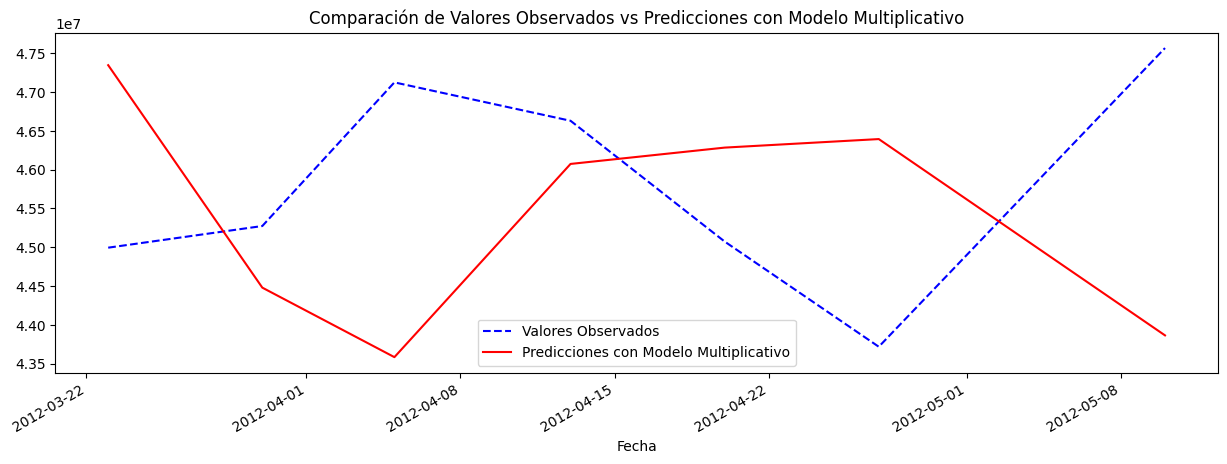

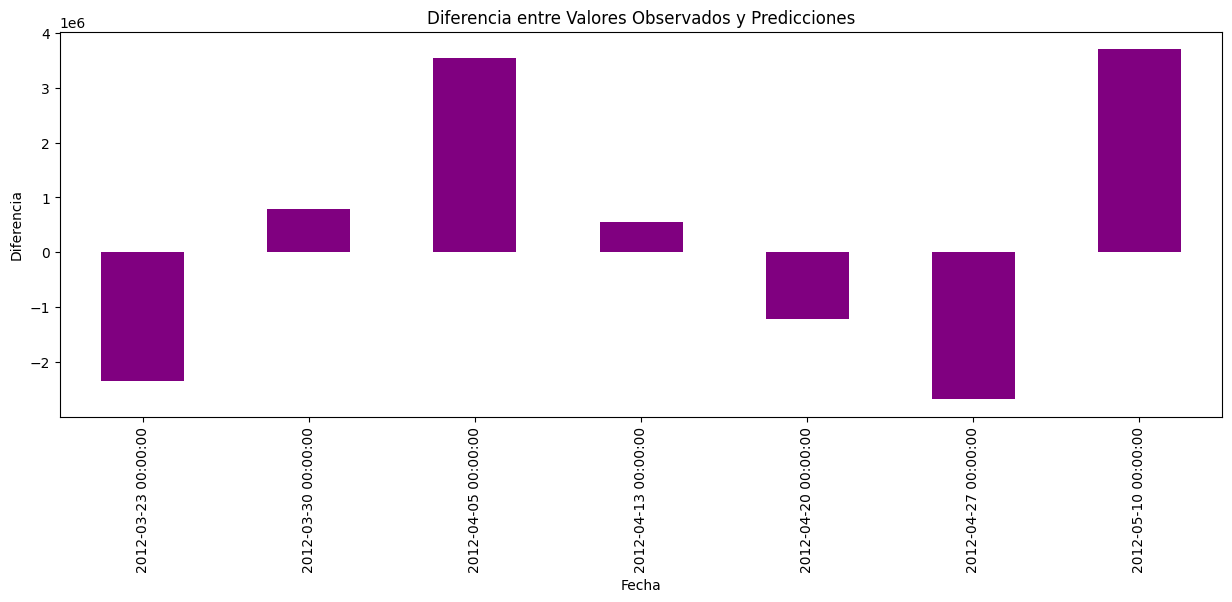

In [118]:
plt.figure(figsize=(15,5))

df_predicciones['y_observado'].plot(label='Valores Observados', color='blue', linestyle='--')
df_predicciones['modelo_multiplicativo'].plot(label='Predicciones con Modelo Multiplicativo', color='red')
plt.title('Comparación de Valores Observados vs Predicciones con Modelo Multiplicativo')
plt.legend(loc='best')
plt.show()
plt.figure(figsize=(15,5))
df_predicciones['diferencia'].plot(kind='bar', color='purple')
plt.title('Diferencia entre Valores Observados y Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Diferencia')
plt.show()

Es posible que el modelo multiplicativo no sea el más adecuado para estos datos específicos o que se requiera una optimización adicional en términos de parámetros. Por lo que corresponde analizar los siguientes modelos AR, MA y ARMA.

### 6.2. Modelo AR

El modelo AR (AutoRegressivo) es un tipo de modelo de series temporales en el que los valores de una serie se pronostican utilizando valores anteriores de la misma serie.

#### 6.2.1. Preparación de Datos

In [119]:
if 'Fecha' in datos.columns:
    datos = datos.drop('Fecha', axis=1)

In [120]:
train = datos['Ventas_Semanales'][:-10]
test = datos['Ventas_Semanales'][-10:]


En este caso se mantendrá las últimas 10 semanas como datos de prueba y el resto para entrenamiento.

#### 6.2.2. Estacionariedad

In [121]:
from statsmodels.tsa.stattools import adfuller

def test_estacionariedad(timeseries):
    print('Resultados de la prueba de Dickey-Fuller:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

test_estacionariedad(train)

Resultados de la prueba de Dickey-Fuller:
Test Statistic                -9.490339e+00
p-value                        3.667172e-16
#Lags Used                     0.000000e+00
Number of Observations Used    1.320000e+02
Critical Value (1%)           -3.480888e+00
Critical Value (5%)           -2.883697e+00
Critical Value (10%)          -2.578586e+00
dtype: float64


La prueba de Dickey-Fuller es utilizada para determinar si una serie temporal es estacionaria. En los resultados presentados, el valor del Test Statistic (-9.49) es más negativo que los valores críticos tanto al 1%, 5% como al 10%. El valor p es extremadamente pequeño (3.67 x 10^-16), mucho menor que cualquier nivel convencional de significancia (como 0.05 o 0.01). Esto implica que podemos rechazar firmemente la hipótesis nula de que la serie tiene una raíz unitaria, indicando que la serie es estacionaria. 

#### 6.2.3. Determinar el Modelo AR(p)

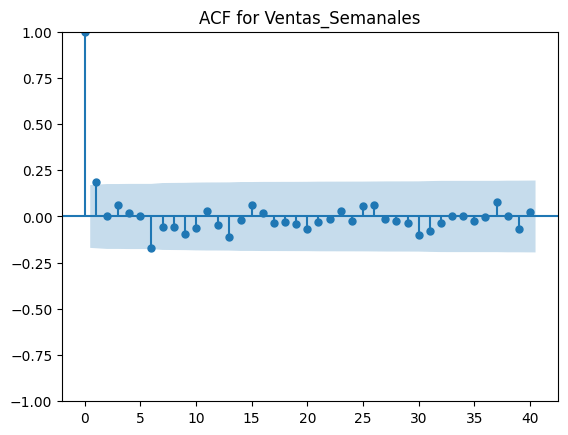

In [122]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(train, lags=40)
plt.title('ACF for Ventas_Semanales')
plt.show()


Un buen punto de partida sería considerar un modelo AR(2) o AR(3) para este conjunto de datos, ya que esos lags son los últimos que presentan una autocorrelación significativa antes de que las barras caigan dentro del intervalo de confianza.

#### 6.2.4. Construcción del Modelo AR

In [123]:
from statsmodels.tsa.ar_model import AutoReg
model1 = AutoReg(train, lags=3)
model_fitted = model1.fit()
print(model_fitted.summary())

                            AutoReg Model Results                             
Dep. Variable:       Ventas_Semanales   No. Observations:                  133
Model:                     AutoReg(3)   Log Likelihood               -2202.465
Method:               Conditional MLE   S.D. of innovations        5515664.498
Date:                Sun, 08 Oct 2023   AIC                           4414.931
Time:                        08:12:04   BIC                           4429.268
Sample:                             3   HQIC                          4420.757
                                  133                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3.676e+07   6.31e+06      5.827      0.000    2.44e+07    4.91e+07
Ventas_Semanales.L1     0.1975      0.087      2.258      0.024       0.026       0.369
Ventas_Semanales

In [124]:
from statsmodels.tsa.ar_model import AutoReg
model2 = AutoReg(train, lags=2)
model_fitted = model2.fit()
print(model_fitted.summary())

                            AutoReg Model Results                             
Dep. Variable:       Ventas_Semanales   No. Observations:                  133
Model:                     AutoReg(2)   Log Likelihood               -2219.255
Method:               Conditional MLE   S.D. of innovations        5509267.667
Date:                Sun, 08 Oct 2023   AIC                           4446.511
Time:                        08:12:04   BIC                           4458.012
Sample:                             2   HQIC                          4451.184
                                  133                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3.962e+07   5.27e+06      7.524      0.000    2.93e+07    4.99e+07
Ventas_Semanales.L1     0.1959      0.087      2.249      0.025       0.025       0.367
Ventas_Semanales

Aunque el modelo AutoReg(3) tiene mejor rendimiento en términos de AIC, BIC y logaritmo de verosimilitud, tiene coeficientes que no son significativos. Por lo tanto, si se desea un modelo más simple, se podría optar por el modelo AutoReg(2), aunque sus indicadores de ajuste son ligeramente peores. Sin embargo, si se prefiere un ajuste marginalmente mejor y está dispuesto a incluir coeficientes no significativos, el modelo AutoReg(3) sería el adecuado. 

#### 6.2.5. Predicciones

In [125]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

preds1 = model1.fit().predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
preds2 = model2.fit().predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

mse1 = mean_squared_error(test, preds1)
mae1 = mean_absolute_error(test, preds1)

mse2 = mean_squared_error(test, preds2)
mae2 = mean_absolute_error(test, preds2)

print(f"Modelo AutoReg(3): Error Cuadrático Medio (MSE): {mse1}, Error Absoluto Medio (MAE): {mae1}")
print(f"Modelo AutoReg(2): Error Cuadrático Medio (MSE): {mse2}, Error Absoluto Medio (MAE): {mae2}")


Modelo AutoReg(3): Error Cuadrático Medio (MSE): 4511459880334.228, Error Absoluto Medio (MAE): 1763785.7397110655
Modelo AutoReg(2): Error Cuadrático Medio (MSE): 4517203621677.525, Error Absoluto Medio (MAE): 1765872.4220349467


En este caso, aunque las diferencias son pequeñas, el modelo AutoReg(3) es ligeramente superior en términos de precisión al modelo AutoReg(2).

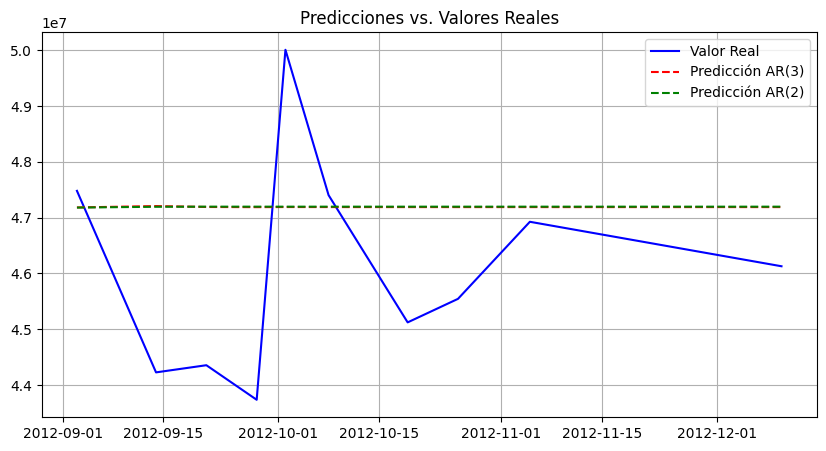

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.plot(test.index, test.values, label='Valor Real', color='blue')

plt.plot(test.index, preds1.values, label='Predicción AR(3)', color='red', linestyle='--')

plt.plot(test.index, preds2.values, label='Predicción AR(2)', color='green', linestyle='--')

plt.title('Predicciones vs. Valores Reales')
plt.legend()
plt.grid(True)
plt.show()


Es evidente que ambos modelos AR(3) y AR(2) no están capturando adecuadamente la variabilidad en los datos, especialmente los picos y las caídas. Las predicciones parecen ser casi constantes a lo largo del tiempo, lo que indica que el modelo AR no está capturando adecuadamente la serie temporal.

### 6.3. Modelo MA

Un modelo MA (Modelo de Media Móvil) es un tipo de modelo de series temporales que utiliza la relación entre una observación actual y una serie de errores de predicción pasados para describir patrones en los datos.

#### 6.3.1 Estacionaridad

In [127]:
from statsmodels.tsa.stattools import adfuller

def test_estacionariedad(timeseries):
    print('Resultados de la prueba de Dickey-Fuller:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

test_estacionariedad(datos["Ventas_Semanales"])

Resultados de la prueba de Dickey-Fuller:
Test Statistic                -9.837722e+00
p-value                        4.845103e-17
#Lags Used                     0.000000e+00
Number of Observations Used    1.420000e+02
Critical Value (1%)           -3.477262e+00
Critical Value (5%)           -2.882118e+00
Critical Value (10%)          -2.577743e+00
dtype: float64


La función test_estacionariedad realiza la prueba de Dickey-Fuller aumentada en una serie temporal para verificar su estacionariedad. Al aplicarla a "Ventas_Semanales", el estadístico de prueba es aproximadamente -9.84, y el p-valor es extremadamente pequeño, muy cerca de cero. Dado que el estadístico de prueba es menor que los valores críticos al 1%, 5% y 10%, la serie "Ventas_Semanales" es estacionaria según esta prueba.

#### 6.3.2 p, d, q

Tras confirmar la estacionariedad de la serie "Ventas_Semanales" con la prueba de Dickey-Fuller, el siguiente paso en el análisis de series temporales es la identificación del orden adecuado para un modelo ARIMA (p, d, q), que combina modelos autoregresivos (AR) y modelos de media móvil (MA).

Para determinar los valores de p y q:

- ACF (Función de Autocorrelación): Ayuda a determinar el orden q del modelo MA.
- PACF (Función de Autocorrelación Parcial): Ayuda a determinar el orden p del modelo AR.

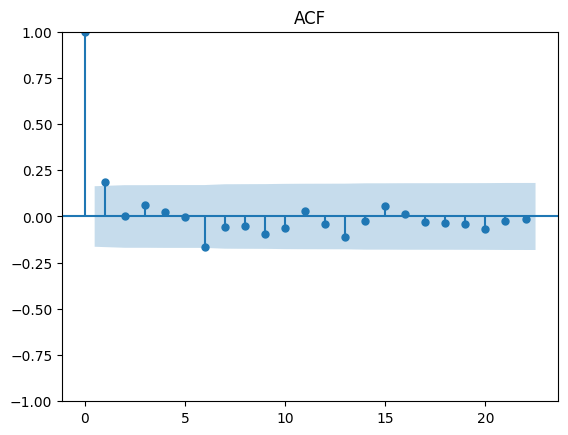

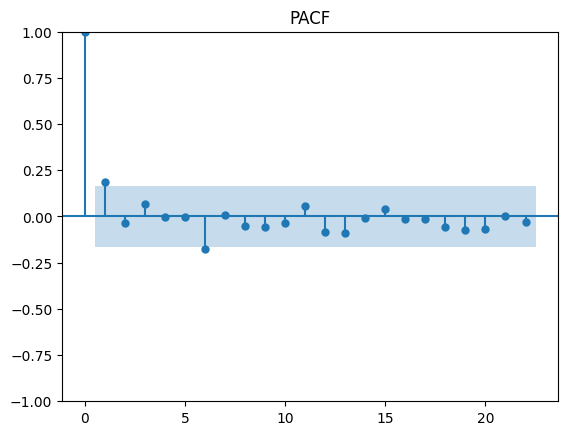

In [128]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Función de autocorrelación
plot_acf(datos['Ventas_Semanales'])
plt.title('ACF')
plt.show()

# Función de autocorrelación parcial
plot_pacf(datos['Ventas_Semanales'])
plt.title('PACF')
plt.show()


- ACF: Observando el gráfico ACF, vemos un decayimiento significativo en el primer retraso y luego se estabiliza, manteniéndose dentro del intervalo de confianza. Esto sugiere que podría ser adecuado un modelo de media móvil de primer orden, es decir, q = 1.
- PACF: En el gráfico PACF, hay un descenso significativo en el primer retraso y después se estabiliza. Esto sugiere que podría ser adecuado un modelo autoregresivo de primer orden, es decir p=1.
- Dado que la serie ya es estacionaria (según la prueba de Dickey-Fuller), el grado de diferenciación d sería 0.

#### 6.3.3 Ajuste del Modelo ARIMA(1,0,1)

El siguiente paso, después de identificar los valores iniciales de p, d, q basados en los gráficos ACF y PACF, es ajustar el modelo ARIMA.

In [129]:
from statsmodels.tsa.arima.model import ARIMA

modelo_arima = ARIMA(datos['Ventas_Semanales'], order=(1,0,1))
resultado_arima = modelo_arima.fit()
print(resultado_arima.summary())


                               SARIMAX Results                                
Dep. Variable:       Ventas_Semanales   No. Observations:                  143
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2417.272
Date:                Sun, 08 Oct 2023   AIC                           4842.544
Time:                        08:12:05   BIC                           4854.395
Sample:                             0   HQIC                          4847.360
                                - 143                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.711e+07   1.34e-08   3.51e+15      0.000    4.71e+07    4.71e+07
ar.L1         -0.7834      0.133     -5.904      0.000      -1.043      -0.523
ma.L1          0.9172      0.091     10.052      0.0

Coeficientes:

- const: La constante del modelo es aproximadamente 4.711e+07.
- ar.L1: El coeficiente autoregresivo de primer orden es -0.7834, lo que sugiere una relación negativa con el valor anterior en la serie.
- ma.L1: El coeficiente de media móvil de primer orden es 0.9172, lo que indica cómo el error en el período anterior afecta el valor actual.
- sigma2: Es la varianza del error del modelo, un valor bastante grande en este caso.


Pruebas y Estadísticas:

- Ljung-Box (L1): Esta prueba evalúa si los residuos son independientes (es decir, no hay autocorrelación). Un valor Prob(Q) superior a 0.05 indica que los residuos son independientes. En este caso, con un valor de 0.32, parece que el modelo captura adecuadamente la estructura de dependencia temporal.
- Jarque-Bera (JB): Es una prueba para evaluar si los residuos tienen una distribución normal. Un valor de Prob(JB) cercano a cero sugiere que los residuos no siguen una distribución normal. Con un valor de 0.00, este es el caso aquí.
- Heteroskedasticity (H): Esta prueba evalúa la homocedasticidad de los residuos. Un valor de Prob(H) superior a 0.05 sugiere homocedasticidad. En este caso, con un valor de 0.48, los residuos parecen ser homocedásticos.
- Skew y Kurtosis: Indican la asimetría y la forma de la distribución de los residuos, respectivamente. Valores de Skew diferentes de 0 sugieren asimetría, y un valor de Kurtosis mayor que 3 indica colas más pesadas que una distribución normal.


Advertencias:
- La matriz de covarianza es singular o cercana a singular, lo que puede sugerir problemas de multicolinealidad o que el modelo está sobreajustado.

#### 6.3.4 Diagnóstico del Modelo

Una vez ajustado el modelo, es importante hacer un diagnóstico para evaluar la calidad del ajuste. Esto incluye revisar los residuos del modelo.

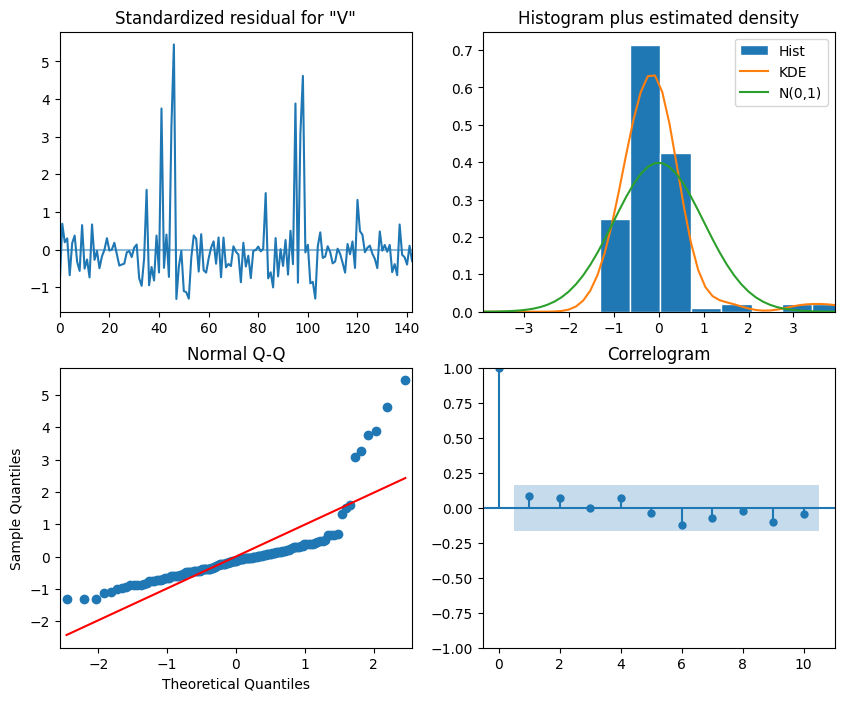

In [130]:
resultado_arima.plot_diagnostics(figsize=(10,8))
plt.show()

- Standardized residual for "V": Este gráfico muestra los residuos estandarizados a lo largo del tiempo. Idealmente, querríamos que estos residuos se asemejaran al ruido blanco, es decir, que no muestren patrones evidentes. En el gráfico, si bien en su mayoría los residuos parecen ser ruido, hay picos notables que sugieren que el modelo no está capturando toda la estructura de los datos.

- Histogram plus estimated density: Muestra la distribución de los residuos. La línea KDE (estimación de densidad del núcleo) debería coincidir lo más cerca posible con la línea N(0,1), que es una distribución normal estándar. Si hay una gran desviación de esta línea, podría indicar que los residuos no están distribuidos normalmente. En este caso, parece que hay una ligera desviación de la normalidad, aunque no es severa.

- Normal Q-Q: Este es un gráfico cuantil-cuantil. Si los residuos están distribuidos normalmente, los puntos deberían seguir la línea roja. En el gráfico, los puntos se desvían de la línea roja en los extremos, lo que sugiere que los residuos tienen colas más pesadas que una distribución normal.

- Correlogram: Muestra la autocorrelación de los residuos. Idealmente, querríamos que los residuos no estuvieran autocorrelacionados, lo que significaría que el modelo ha capturado toda la estructura temporal de los datos. Si los puntos están dentro del área sombreada azul, sugiere que los residuos no están autocorrelacionados. En el gráfico, parece que la mayoría de los residuos, si no todos, están dentro de la zona azul, lo que es una señal positiva.

#### 6.3.5 Validación del Modelo

La validación del modelo utilizando un conjunto de entrenamiento y un conjunto de prueba es crucial para evaluar cómo se desempeñará el modelo en datos no vistos previamente. 

In [131]:
tamaño_entrenamiento = int(len(datos) * 0.8)
datos_entrenamiento = datos['Ventas_Semanales'][:tamaño_entrenamiento]
datos_prueba = datos['Ventas_Semanales'][tamaño_entrenamiento:]

Primero, se divide los datos en conjuntos de entrenamiento y prueba. Una práctica común es utilizar la mayoría de los datos para entrenamiento y una pequeña porción (como el 20%) para pruebas.

In [132]:
modelo = ARIMA(datos_entrenamiento, order=(1,0,1))
resultado = modelo.fit()

Predicciones para el período que abarca el conjunto de prueba.

In [133]:
inicio = len(datos_entrenamiento)
fin = inicio + len(datos_prueba) - 1

predicciones = resultado.predict(start=inicio, end=fin, typ='levels')
predicciones.index = datos_prueba.index


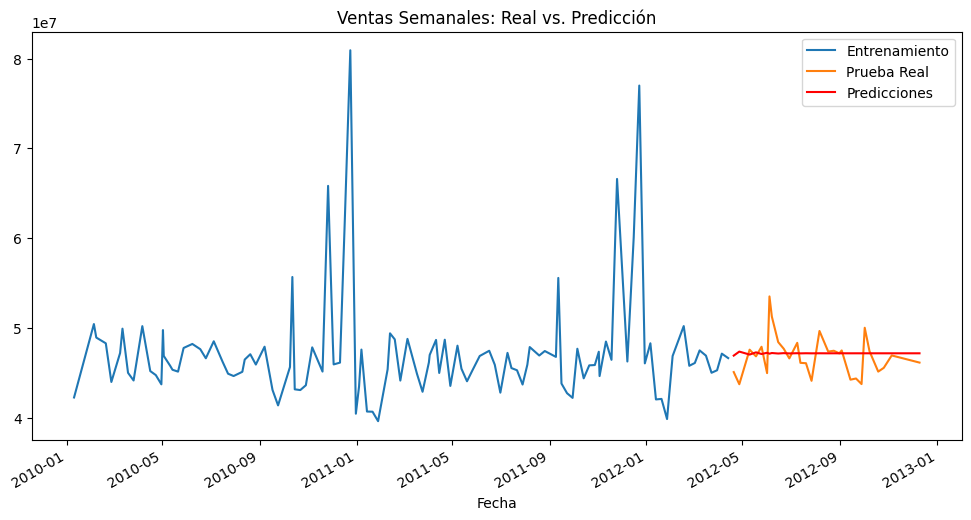

In [134]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
datos['Ventas_Semanales'][:tamaño_entrenamiento].plot(label='Entrenamiento')
datos['Ventas_Semanales'][tamaño_entrenamiento:].plot(label='Prueba Real')
predicciones.plot(label='Predicciones', color='red')
plt.legend()
plt.title('Ventas Semanales: Real vs. Predicción')
plt.show()


El modelo actual, aunque sigue una tendencia similar, no logra capturar completamente los patrones y fluctuaciones presentes en los datos reales. Específicamente, el modelo no ha logrado predecir el pico observado en 2012, lo que sugiere que hay ciertos factores o patrones en los datos que el modelo no ha considerado.

### 6.4. Modelo SARIMAX

El modelo ARIMA está diseñado específicamente para modelar series temporales univariadas. Sin embargo, si se desea incluir variables exógenas (es decir, otras variables independientes) en el modelo, se considera el modelo SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables).

El modelo SARIMAX no solo tiene componentes estacionales (SARIMA) sino que también permite incluir variables exógenas. Las variables exógenas son aquellas que no forman parte de la serie temporal que estás tratando de predecir pero pueden influir en ella.

#### 6.4.1 División de Datos

In [135]:
tamaño_entrenamiento = int(len(datos) * 0.8) 
entrenamiento = datos[:tamaño_entrenamiento]
prueba = datos[tamaño_entrenamiento:]

#### 6.4.2 Especificación del Modelo:

Se utilizan los valores calculados en el modelo anterior para p, d, q.

In [175]:
p = 1
d = 1
q = 1

S = 52 #periodicidad estacional (semanas)
D = 1 #diferenciar la serie no aplica porque es estacionaria
P = 1
Q = 1

modelo = sm.tsa.statespace.SARIMAX(entrenamiento['Ventas_Semanales'],
                                  exog=entrenamiento[['Bandera_Festivo', 'Precio_Combustible', 'IPC', 'Desempleo']],
                                  order=(p, d, q),
                                  seasonal_order=(P, D, Q, S))

resultados = modelo.fit()
print(resultados.summary())

                                     SARIMAX Results                                      
Dep. Variable:                   Ventas_Semanales   No. Observations:                  114
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -1022.450
Date:                            Sun, 08 Oct 2023   AIC                           2062.900
Time:                                    08:27:44   BIC                           2081.898
Sample:                                         0   HQIC                          2070.345
                                            - 114                                         
Covariance Type:                              opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Bandera_Festivo     6.492e+06    8.5e+04     76.374      0.000    6.33e+06    6.66e+06
Precio_Comb

El modelo actual, que excluye la variable 'Temperatura', parece tener un mejor ajuste basado en las métricas AIC y BIC en comparación con el modelo anterior.

#### 6.4.3. Validación

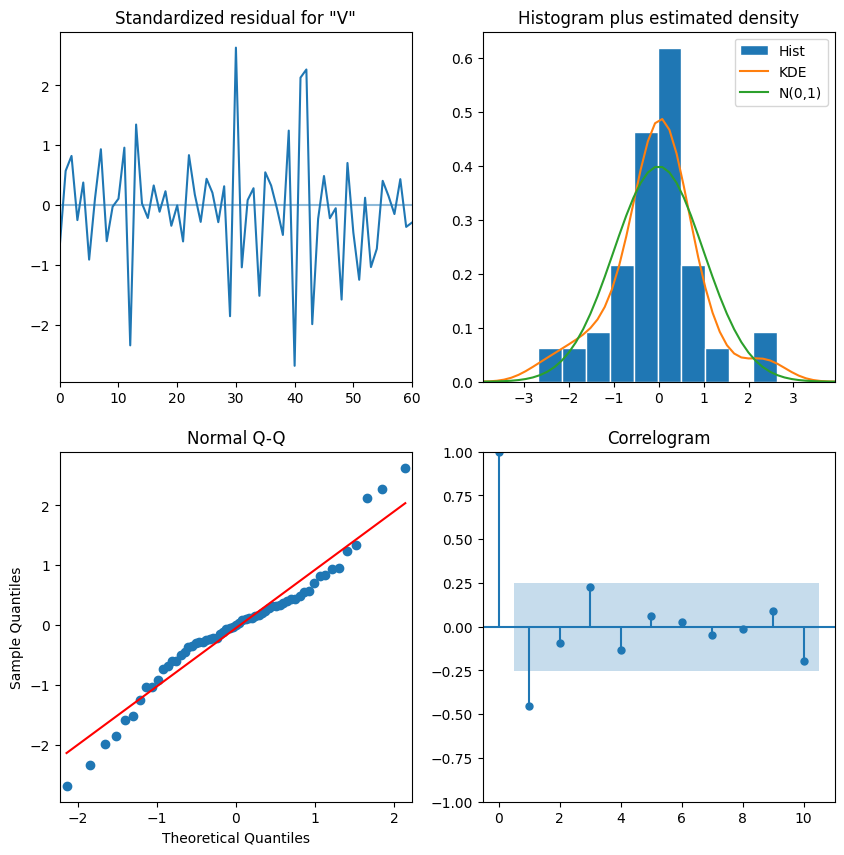

In [176]:
resultados.plot_diagnostics(figsize=(10, 10))
plt.show()


- Residuales Estandarizados: En este gráfico, hay ciertas áreas con volatilidad alta, lo que sugiere que el modelo puede no estar capturando toda la estructura de los datos.
- Histograma y KDE: Aquí, los residuales parecen estar ligeramente desviados de una distribución normal, aunque no demasiado lejos.
- Normal Q-Q: En este caso, la mayoría de los puntos están cerca de la línea, pero hay algunos desvíos, especialmente en los extremos. Esto indica desviaciones de la normalidad, especialmente en los colas.
- Correlograma: En este caso, la mayoría de las correlaciones están dentro de las bandas de confianza azules, lo que es una señal positiva, aunque hay uno o dos que están en el límite o ligeramente fuera de las bandas.


#### 6.4.4. Modelo Definitivo

Para evaluar el modelo SARIMA ajustado, primero generamos predicciones utilizando un conjunto de prueba independiente. Luego, calculamos métricas de rendimiento para comparar las predicciones con los valores reales en el conjunto de prueba. Estas métricas incluyen el Error Cuadrático Medio (MSE), el Error Absoluto Medio (MAE) y el Error Porcentual Absoluto Medio (MAPE). Un bajo MSE y MAE, junto con un MAPE bajo, indican un buen ajuste del modelo y predicciones precisas. Además, podemos visualizar las predicciones en un gráfico para una comprensión intuitiva del rendimiento del modelo en comparación con los datos reales. 

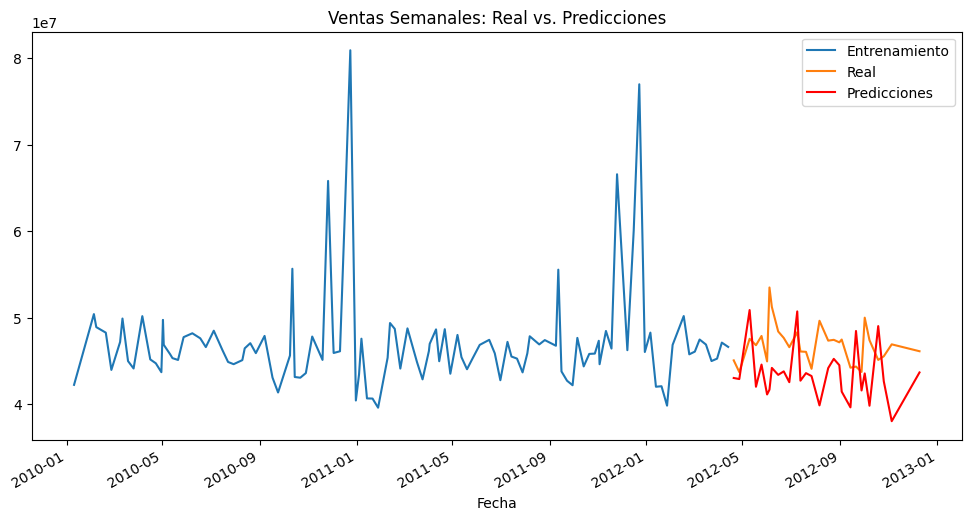

In [177]:
# Asegúrate de que los índices de entrenamiento y prueba estén en el formato de fecha correcto

# Realiza predicciones para el rango de fechas en el conjunto de prueba
prediccion = resultados.get_prediction(start=114, end=142, dynamic=False, exog=prueba[['Bandera_Festivo', 'Precio_Combustible', 'IPC', 'Desempleo']])

# Obtiene la media de las predicciones
prediccion_media = prediccion.predicted_mean
prediccion_media = pd.Series(prediccion_media.values,index=prueba["Ventas_Semanales"].index)


# Graficar resultados
plt.figure(figsize=(12, 6))
entrenamiento['Ventas_Semanales'].plot(label='Entrenamiento')
prueba['Ventas_Semanales'].plot(label='Real')
prediccion_media.plot(label='Predicciones', color='red')
plt.legend()
plt.title('Ventas Semanales: Real vs. Predicciones')
plt.show()



In [178]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcular MSE y MAE
mse = mean_squared_error(prueba['Ventas_Semanales'], prediccion_media)
mae = mean_absolute_error(prueba['Ventas_Semanales'], prediccion_media)

print(f'MSE: {mse}')
print(f'MAE: {mae}')


MSE: 25462162070910.59
MAE: 4338483.993550906


Los resultados del modelo SARIMA indican un Error Cuadrático Medio (MSE) de aproximadamente 25,462,162,070,910.59 y un Error Absoluto Medio (MAE) de aproximadamente 4,338,483.99 en el conjunto de prueba. Estas métricas son bastante elevadas y sugieren que el modelo puede no estar proporcionando predicciones precisas para las ventas semanales.

Lamentablemente, debido a la variabilidad limitada de los datos y la escasez de observaciones disponibles, no es posible desarrollar un modelo altamente preciso y robusto. Los modelos de series temporales, como el SARIMA, requieren un histórico de datos significativo y una estructura temporal más estable para realizar predicciones precisas. En este caso, la falta de datos y la variabilidad inherente limitan nuestra capacidad para construir un modelo que capture de manera efectiva los patrones subyacentes en los datos.

## 7. Conclusión

El modelo SARIMA que se ajustó incluyó una serie de coeficientes para las variables exógenas, como 'Bandera_Festivo', 'Precio_Combustible', 'IPC' y 'Desempleo'. Al analizar estos coeficientes, se pueden obtener algunas interpretaciones:

'Bandera_Festivo': El coeficiente positivo para esta variable sugiere que los días festivos tienen un impacto positivo en las ventas semanales. Es decir, durante los días festivos, es probable que las ventas aumenten en comparación con los días no festivos.

'Precio_Combustible': El coeficiente positivo para esta variable indica que un aumento en el precio del combustible se asocia con un aumento en las ventas semanales. Esto puede ser inusual y puede requerir una investigación adicional, ya que normalmente se esperaría que un aumento en el precio del combustible tenga un efecto negativo en el gasto del consumidor y, por lo tanto, en las ventas.

'IPC' (Índice de Precios al Consumidor): El coeficiente negativo para esta variable sugiere que un aumento en el IPC se asocia con una disminución en las ventas semanales. Esto es consistente con la intuición de que un aumento en los precios puede llevar a una disminución en el poder adquisitivo de los consumidores y, por lo tanto, a una reducción en las ventas.

'Desempleo': El coeficiente negativo para esta variable indica que un aumento en la tasa de desempleo se asocia con una disminución en las ventas semanales. Esto es coherente con la idea de que un alto desempleo puede llevar a una disminución en el gasto del consumidor y, por lo tanto, en las ventas.

A pesar de estas interpretaciones, es importante destacar que el modelo SARIMA final arrojó métricas de rendimiento (MSE y MAE) bastante altas en el conjunto de prueba, lo que indica que las predicciones no se ajustaron adecuadamente a los datos reales. Esto sugiere que, aunque los coeficientes pueden proporcionar cierta información sobre la relación entre las variables exógenas y las ventas, el modelo en su conjunto no pudo capturar la variabilidad y la dinámica subyacente de los datos de manera efectiva.